In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [5]:
from statsmodels.regression.linear_model import OLS

In [6]:
df = load_pd_df("df_analysis.feather", DATA_DIR)

# Macro Time Series Error analysis

## Dräger (2015) rationality test

In [7]:
sub1 = pd_groupby(df.set_index('date_recorded').sort_index(), ['pi_de_Y', 'pi_perc_MY',], 'M', 'last')
sub1 = sub1.dropna()
sub1 = sm.add_constant(sub1)

mod1 = OLS(sub1.pi_de_Y, sub1.drop('pi_de_Y', axis=1)).fit()

In [8]:
sub2 = pd_groupby(df.set_index('date_forecast').sort_index(), ['pi_de_Y', 'pi_exp_MY',], 'M', 'last')
sub2 = sub2.dropna()
sub2 = sm.add_constant(sub2)

mod2 = OLS(sub2.pi_de_Y, sub2.drop('pi_de_Y', axis=1)).fit()

In [9]:
sub3 = pd_groupby(df.set_index('date_forecast').sort_index(), ['pi_de_Y_diff', 'delta_pe_MY',], 'M', 'last')
sub3 = sub3.dropna()
sub3 = sm.add_constant(sub3)

mod3 = OLS(sub3.pi_de_Y_diff, sub3.drop('pi_de_Y_diff', axis=1)).fit()

In [10]:
out = get_statsmodels_summary([mod1, mod2, mod3], cols_out=['print', 'conf_lower', 'conf_upper']).round(3)
save_pd_df(out, "tab_rationality_test.csv", GRAPHS_DIR)
out

print                                             \
                         pi_de_Y             pi_de_Y_1         pi_de_Y_diff   
const        -0.015 **\n[-2.556]  -0.044 ***\n[-7.723]   0.023 ***\n[4.691]   
delta_pe_MY                  NaN                   NaN  -1.238 **\n[-2.656]   
pi_exp_MY                    NaN   1.811 ***\n[17.538]                  NaN   
pi_perc_MY   1.334 ***\n[12.794]                   NaN                  NaN   
N                           34.0                  36.0                 34.0   
R^2                        0.836                   0.9                0.181   
R^2 adj.                   0.831                 0.898                0.155   

            conf_lower                        conf_upper            \
               pi_de_Y pi_de_Y_1 pi_de_Y_diff    pi_de_Y pi_de_Y_1   
const           -0.028    -0.056        0.013     -0.003    -0.033   
delta_pe_MY        NaN       NaN       -2.187        NaN       NaN   
pi_exp_MY          NaN     1.602          NaN        NaN     2.021   
pi_perc_MY       1.122       NaN          NaN      1.546       NaN   
N               34.000    36.000       34.000     34.000    36.000   
R^2              0.836     0.900        0.181      0.836     0.900   
R^2 adj.         0.831     0.898        0.155      0.831     0.898   

                          
            pi_de_Y_diff  
const              0.033  
delta_pe_MY       -0.289  
pi_exp_MY            NaN  
pi_perc_MY           NaN  
N                 34.000  
R^2                0.181  
R^2 adj.           0.155

In [12]:
import pymc as pm
import arviz as az

In [13]:
with pm.Model() as mod:
    alpha = pm.Normal('alpha', 0, 10, shape=(1,))
    beta = pm.Normal('beta', 0, 10, shape=(1,))
    sigma = pm.HalfNormal('sigma', 2, shape=(1,))
    
    mu = pm.Deterministic('mu', alpha + sub2.pi_exp_MY.values[:,None] @ beta)
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=sub2.pi_de_Y)
    
    idata = pm.sample(nuts_sampler='numpyro')
    posterior = pm.sample_posterior_predictive(idata)    

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:05.151223
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:09.862072
Transforming variables...
Transformation time =  0:00:00.265760


Sampling: [likelihood]


''

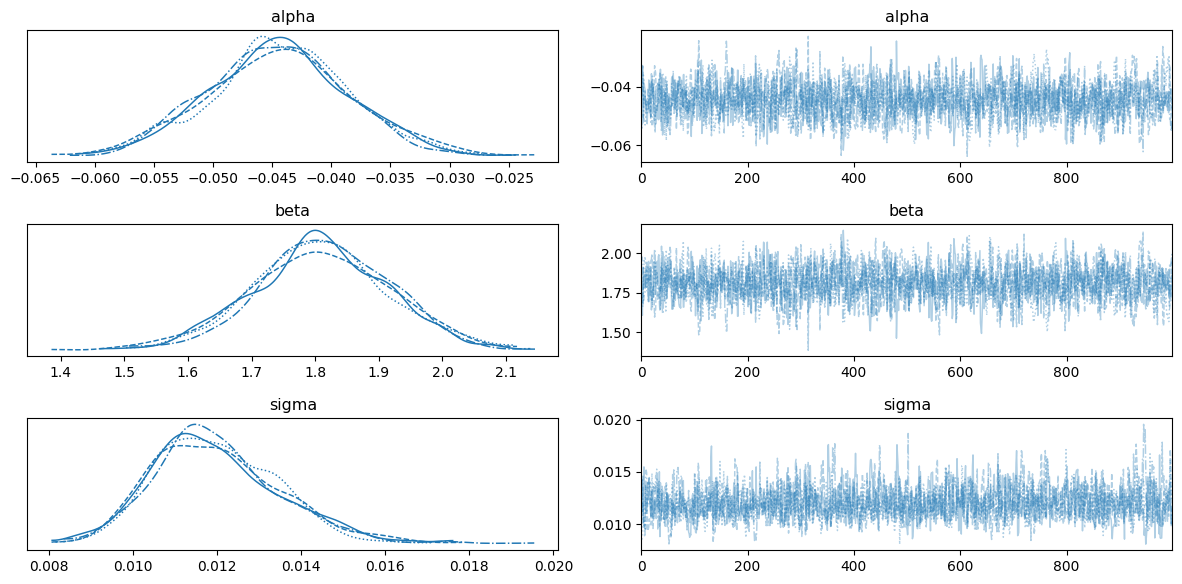

In [14]:
az.plot_trace(idata, var_names=['alpha', 'beta', 'sigma'])
plt.tight_layout()
;

## Cross corr

In [11]:
sub = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_MY', 'pi_perc_MY_all_error_act_MY', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_de_Y',]
].drop_duplicates()
sub2 = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_WY', 'pi_perc_MY_all_error_act_WY', 'T_sum_ind_op_diff']
].drop_duplicates()

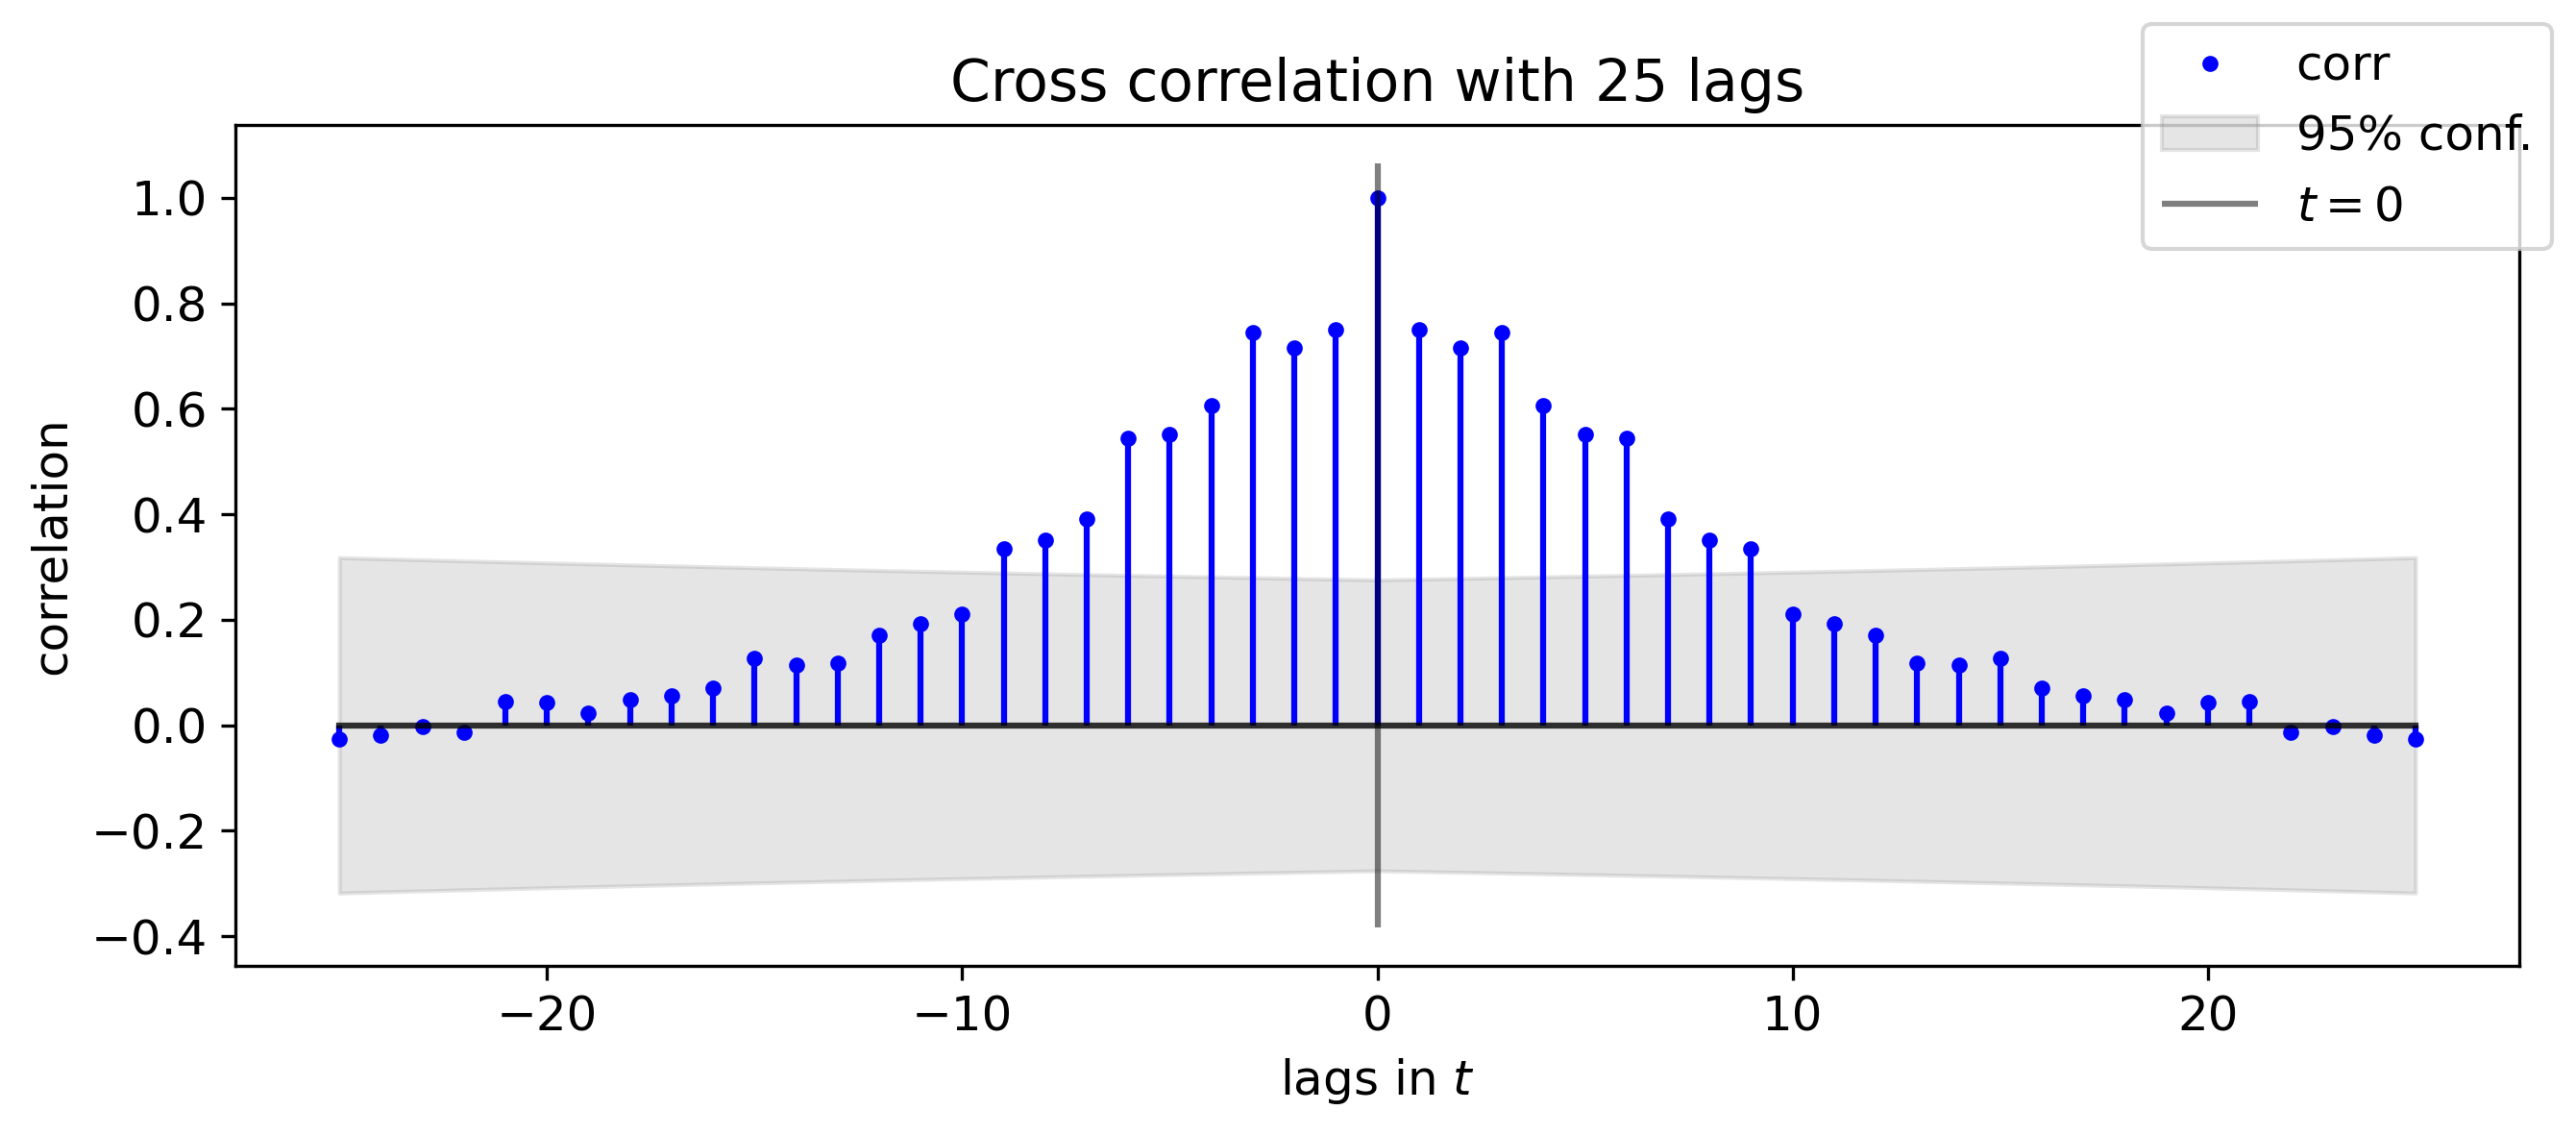

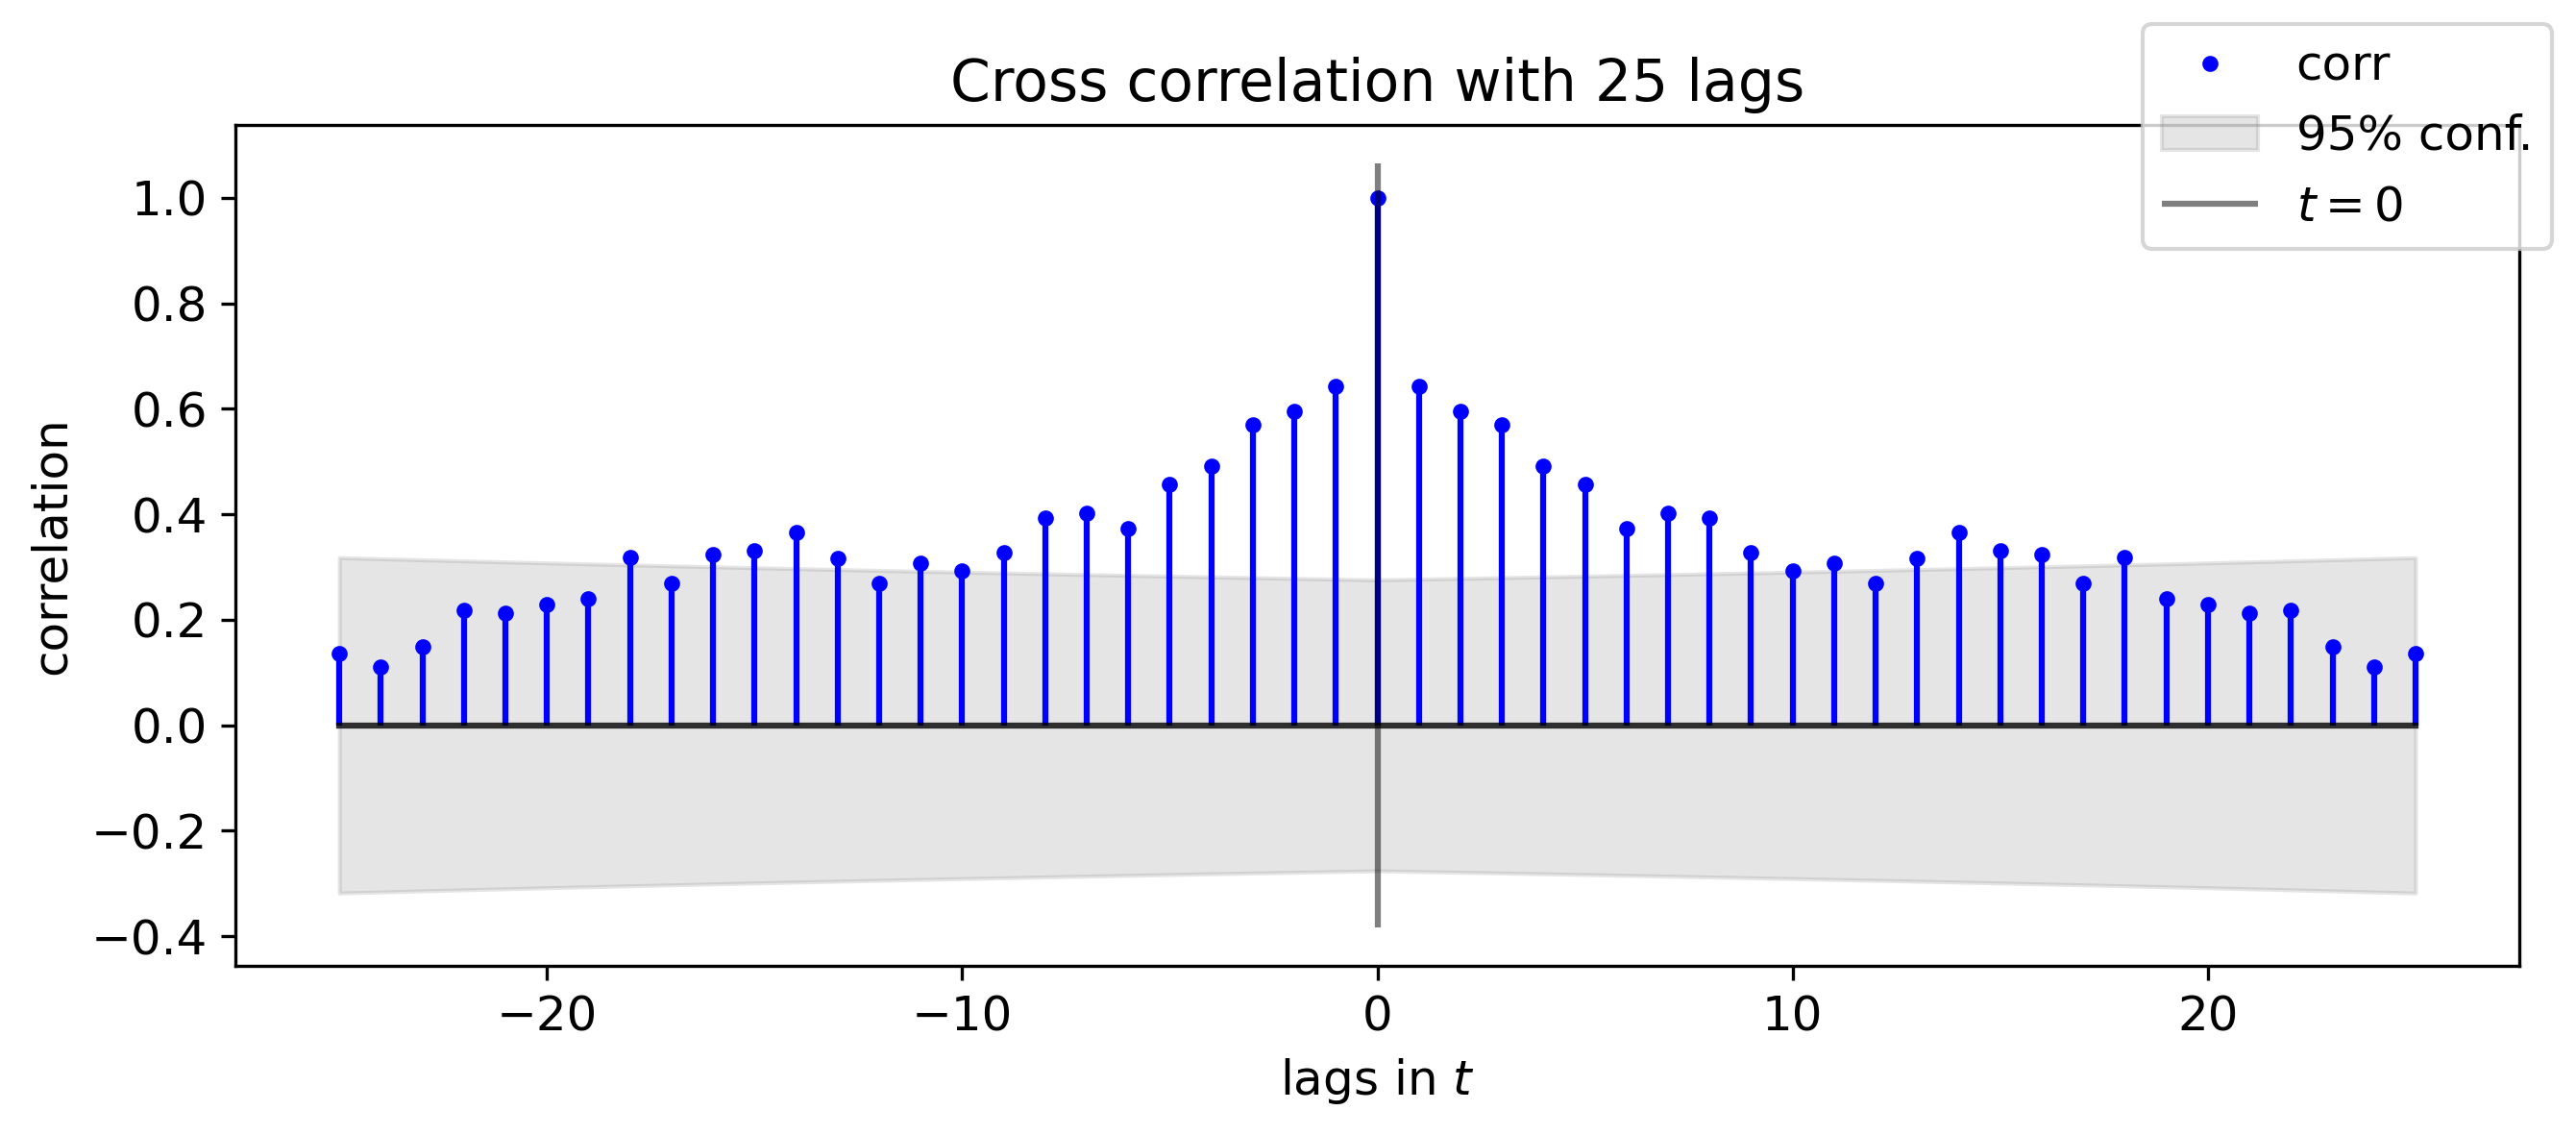

In [12]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, dpi=300, n_lags=25, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_perc_acorr.png')
_, _, _, fig = xcorr(sub2.delta_pe_MY_error_act_WY, dpi=300, n_lags=25, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_delta_pe_acorr.png')

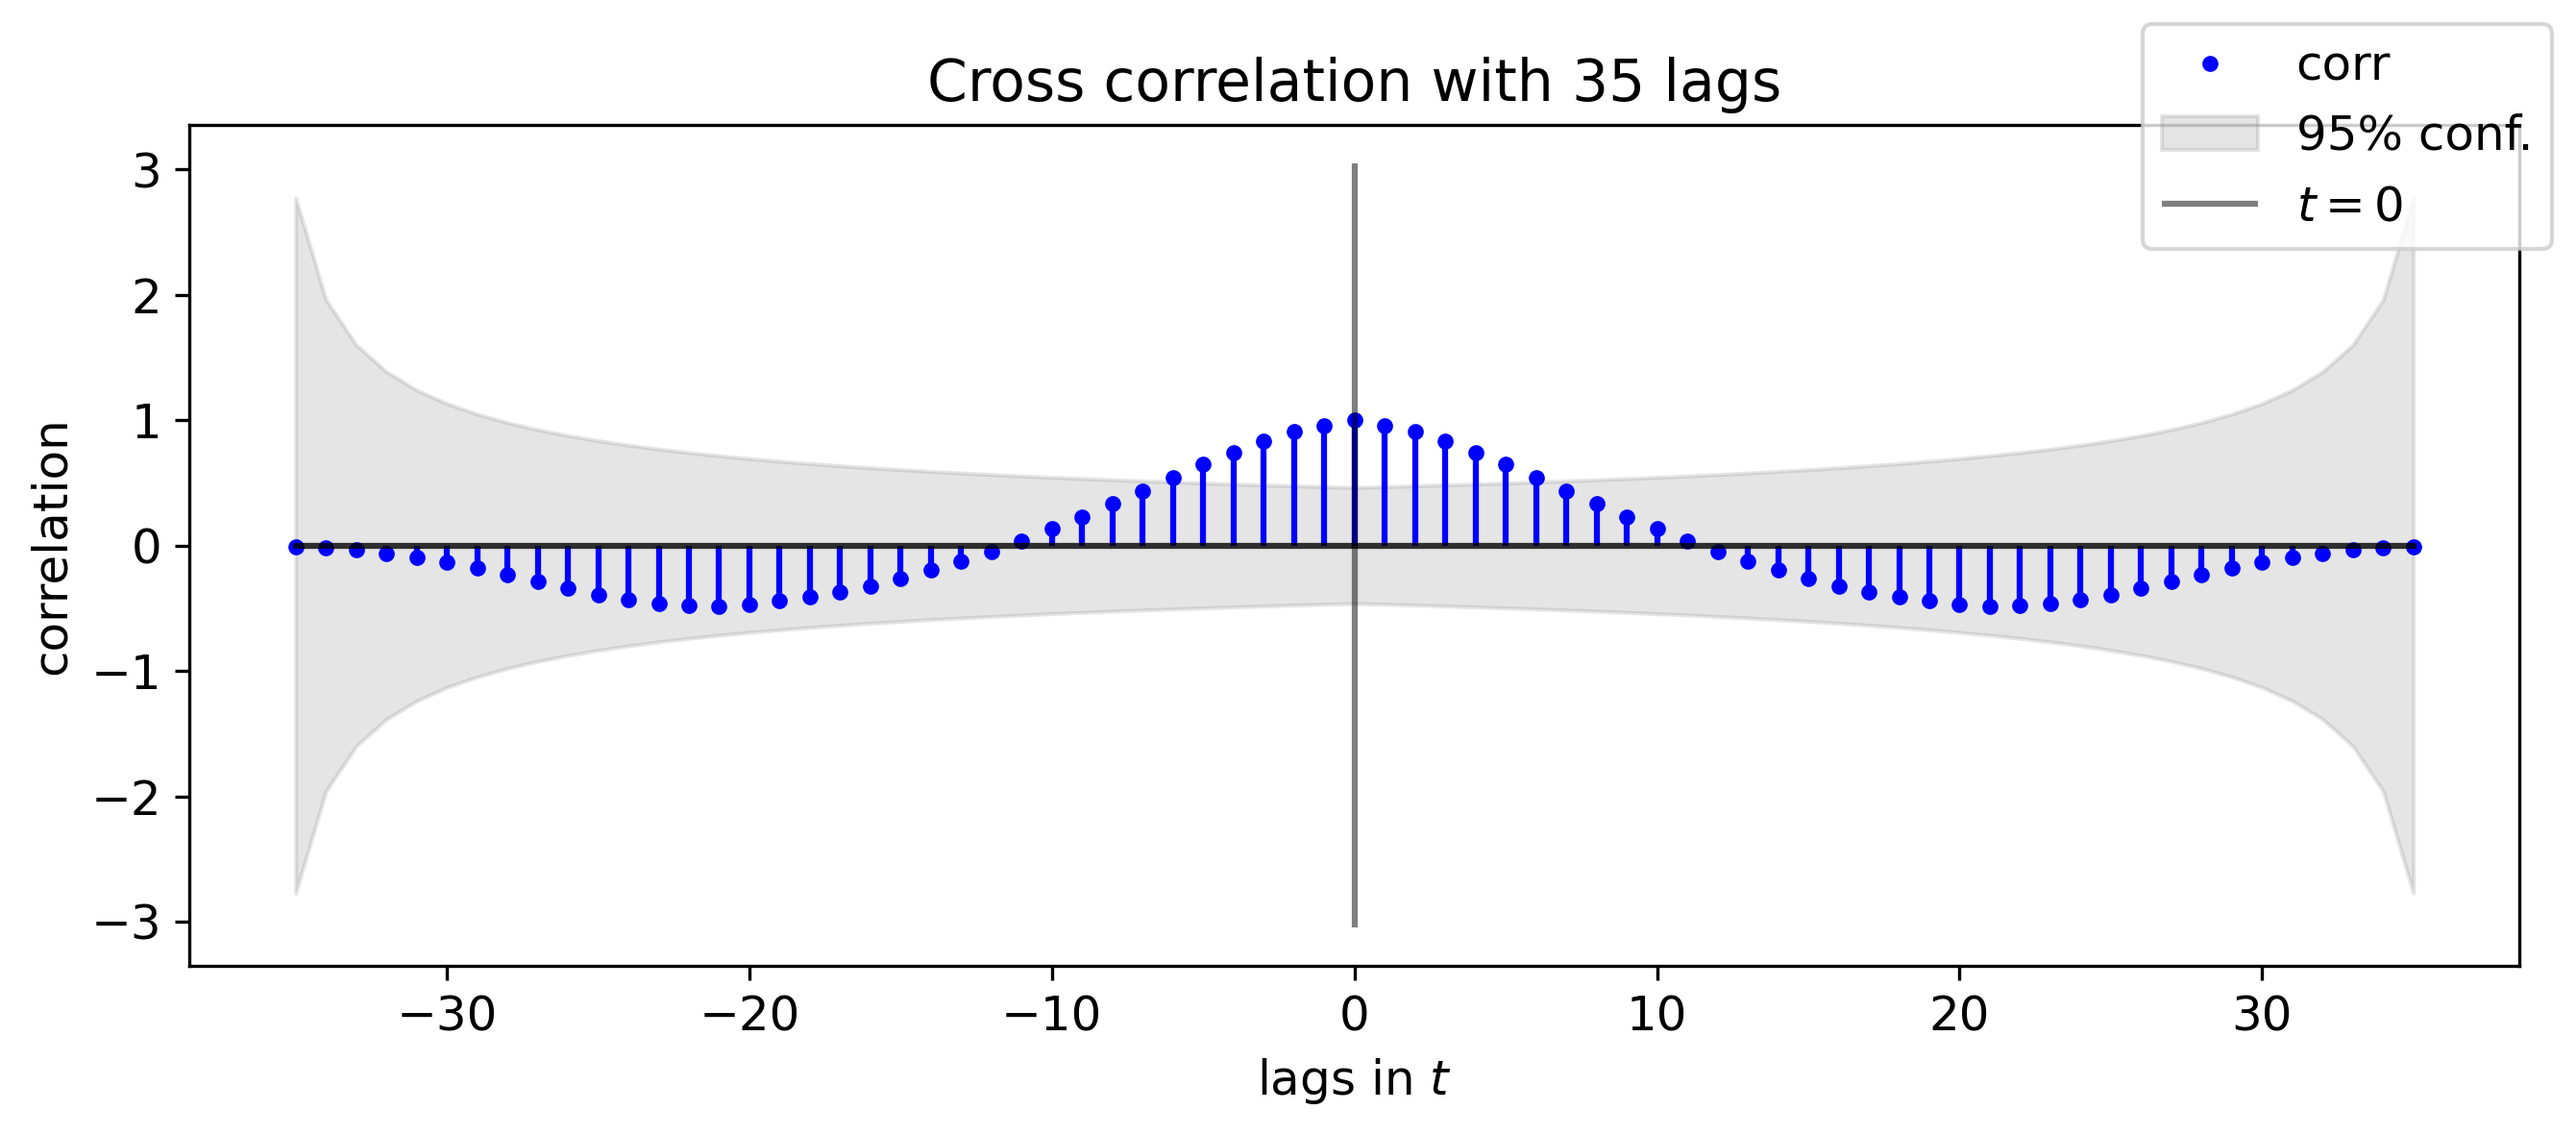

In [13]:
_, _, _, fig = xcorr(sub.pi_de_estimate_Y, dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_structural_acorr.png')

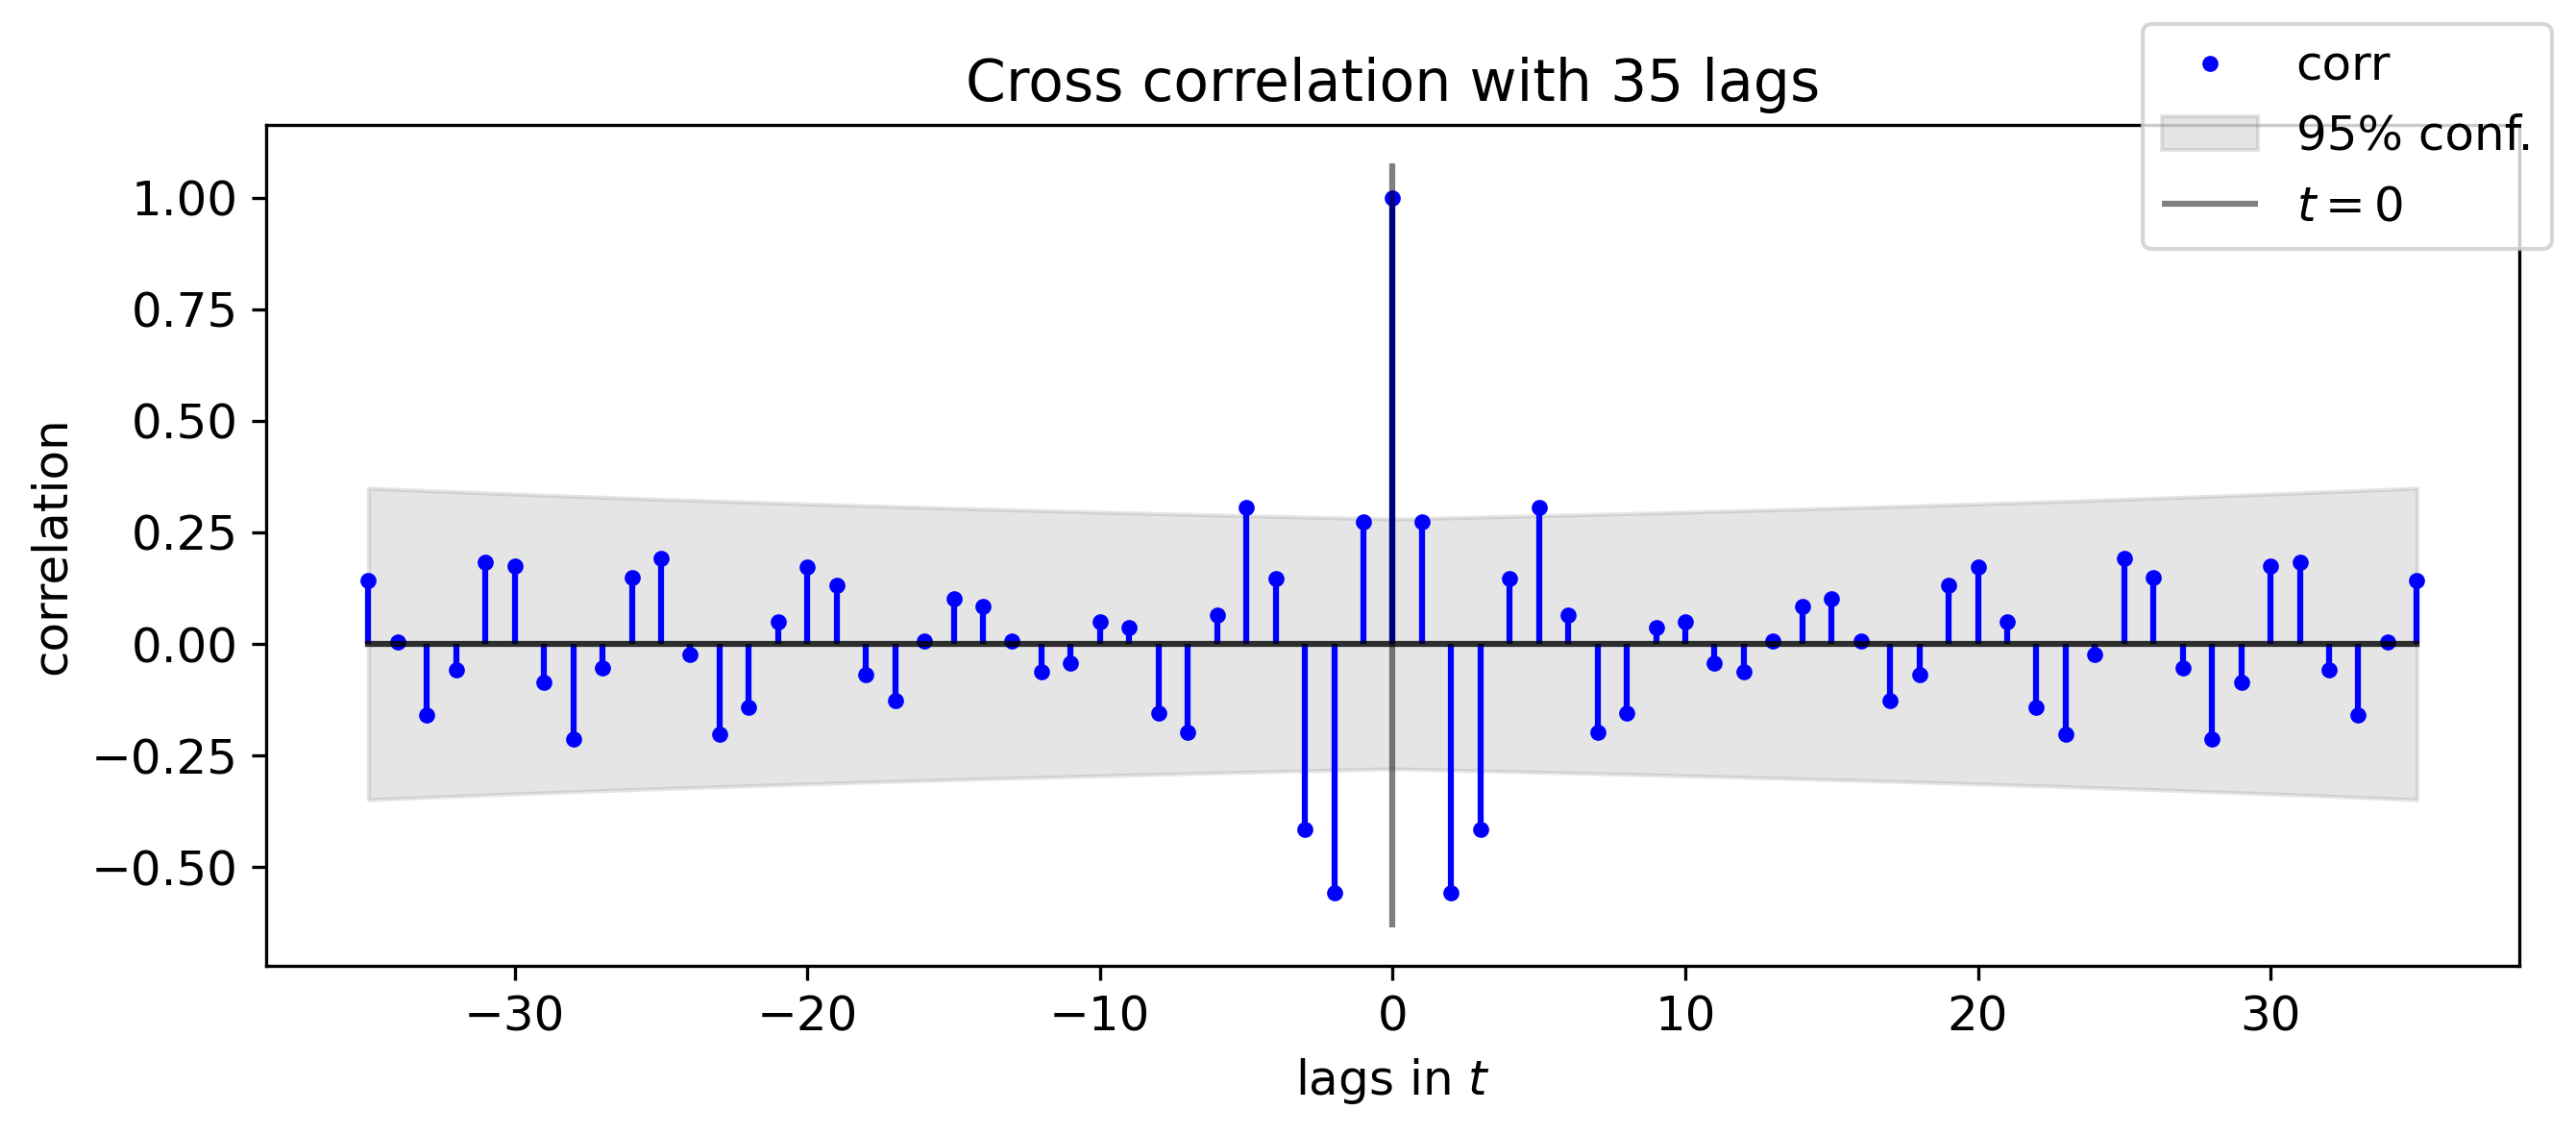

In [14]:
_, _, _, fig = xcorr(sub2.T_sum_ind_op_diff.dropna(), dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_T_sum_acorr.png')

## VECM

In [25]:
df_sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'pi_perc_MY_error_act',
                  'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_perc_MY_S_error_act', 'i_exp_WY',
                  'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum_ind_op', 'T_sum_ind_op_diff', 'T_sum_raw']
                 , 'M', 'last')
df_sub = pd_join_freq(df_sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
df_sub['pi_perc_MY_error_act'] /= 100
df_sub['delta_pe_MY_error_act_MY'] /= 10
t_sum_var = 'T_sum_ind_op'

### pi perc

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_exp_MY ADF p-val: 0.14479079097337977
4
2 0


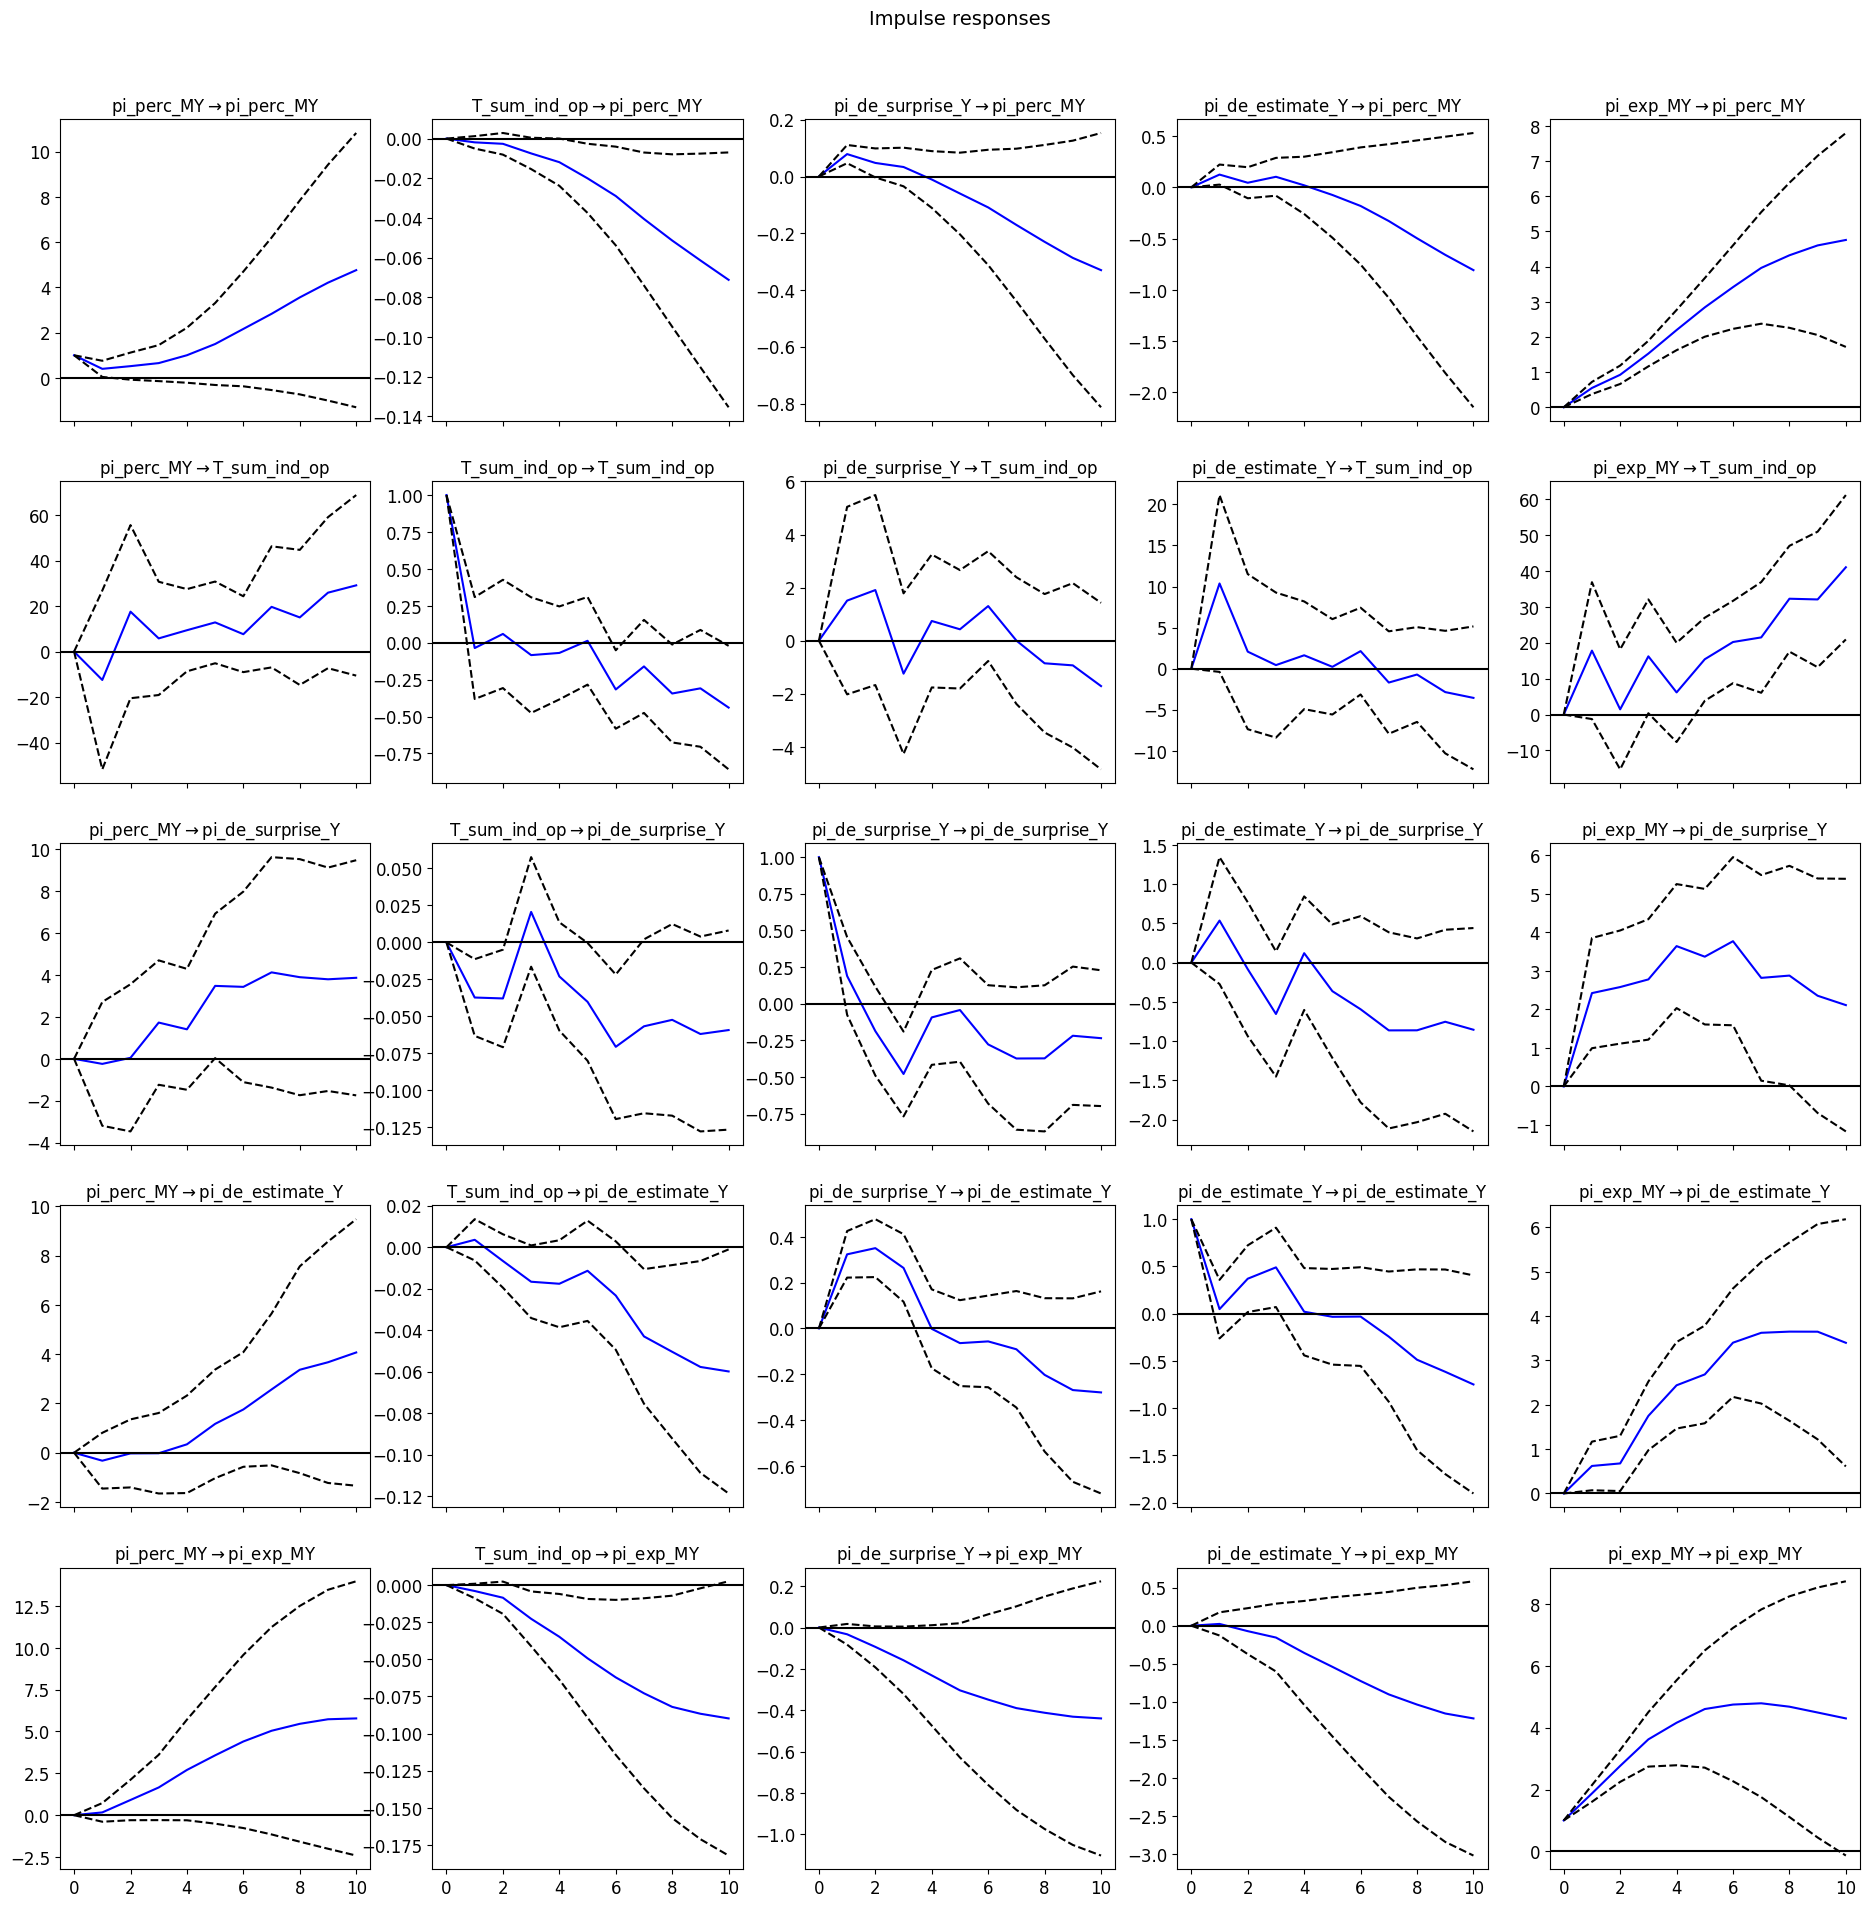

In [26]:
cols_endog, cols_exog = ['pi_perc_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY',]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2, deterministic='ci')
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm1.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_perc.png');

### pi perc error

pi_perc_MY_error_act ADF p-val: 1.974540165527414e-08
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y ADF p-val: 0.29697134223635535
pi_de_estimate_Y ADF p-val: 0.7775251260405094
pi_exp_MY ADF p-val: 0.2551156035612694
3
3 0


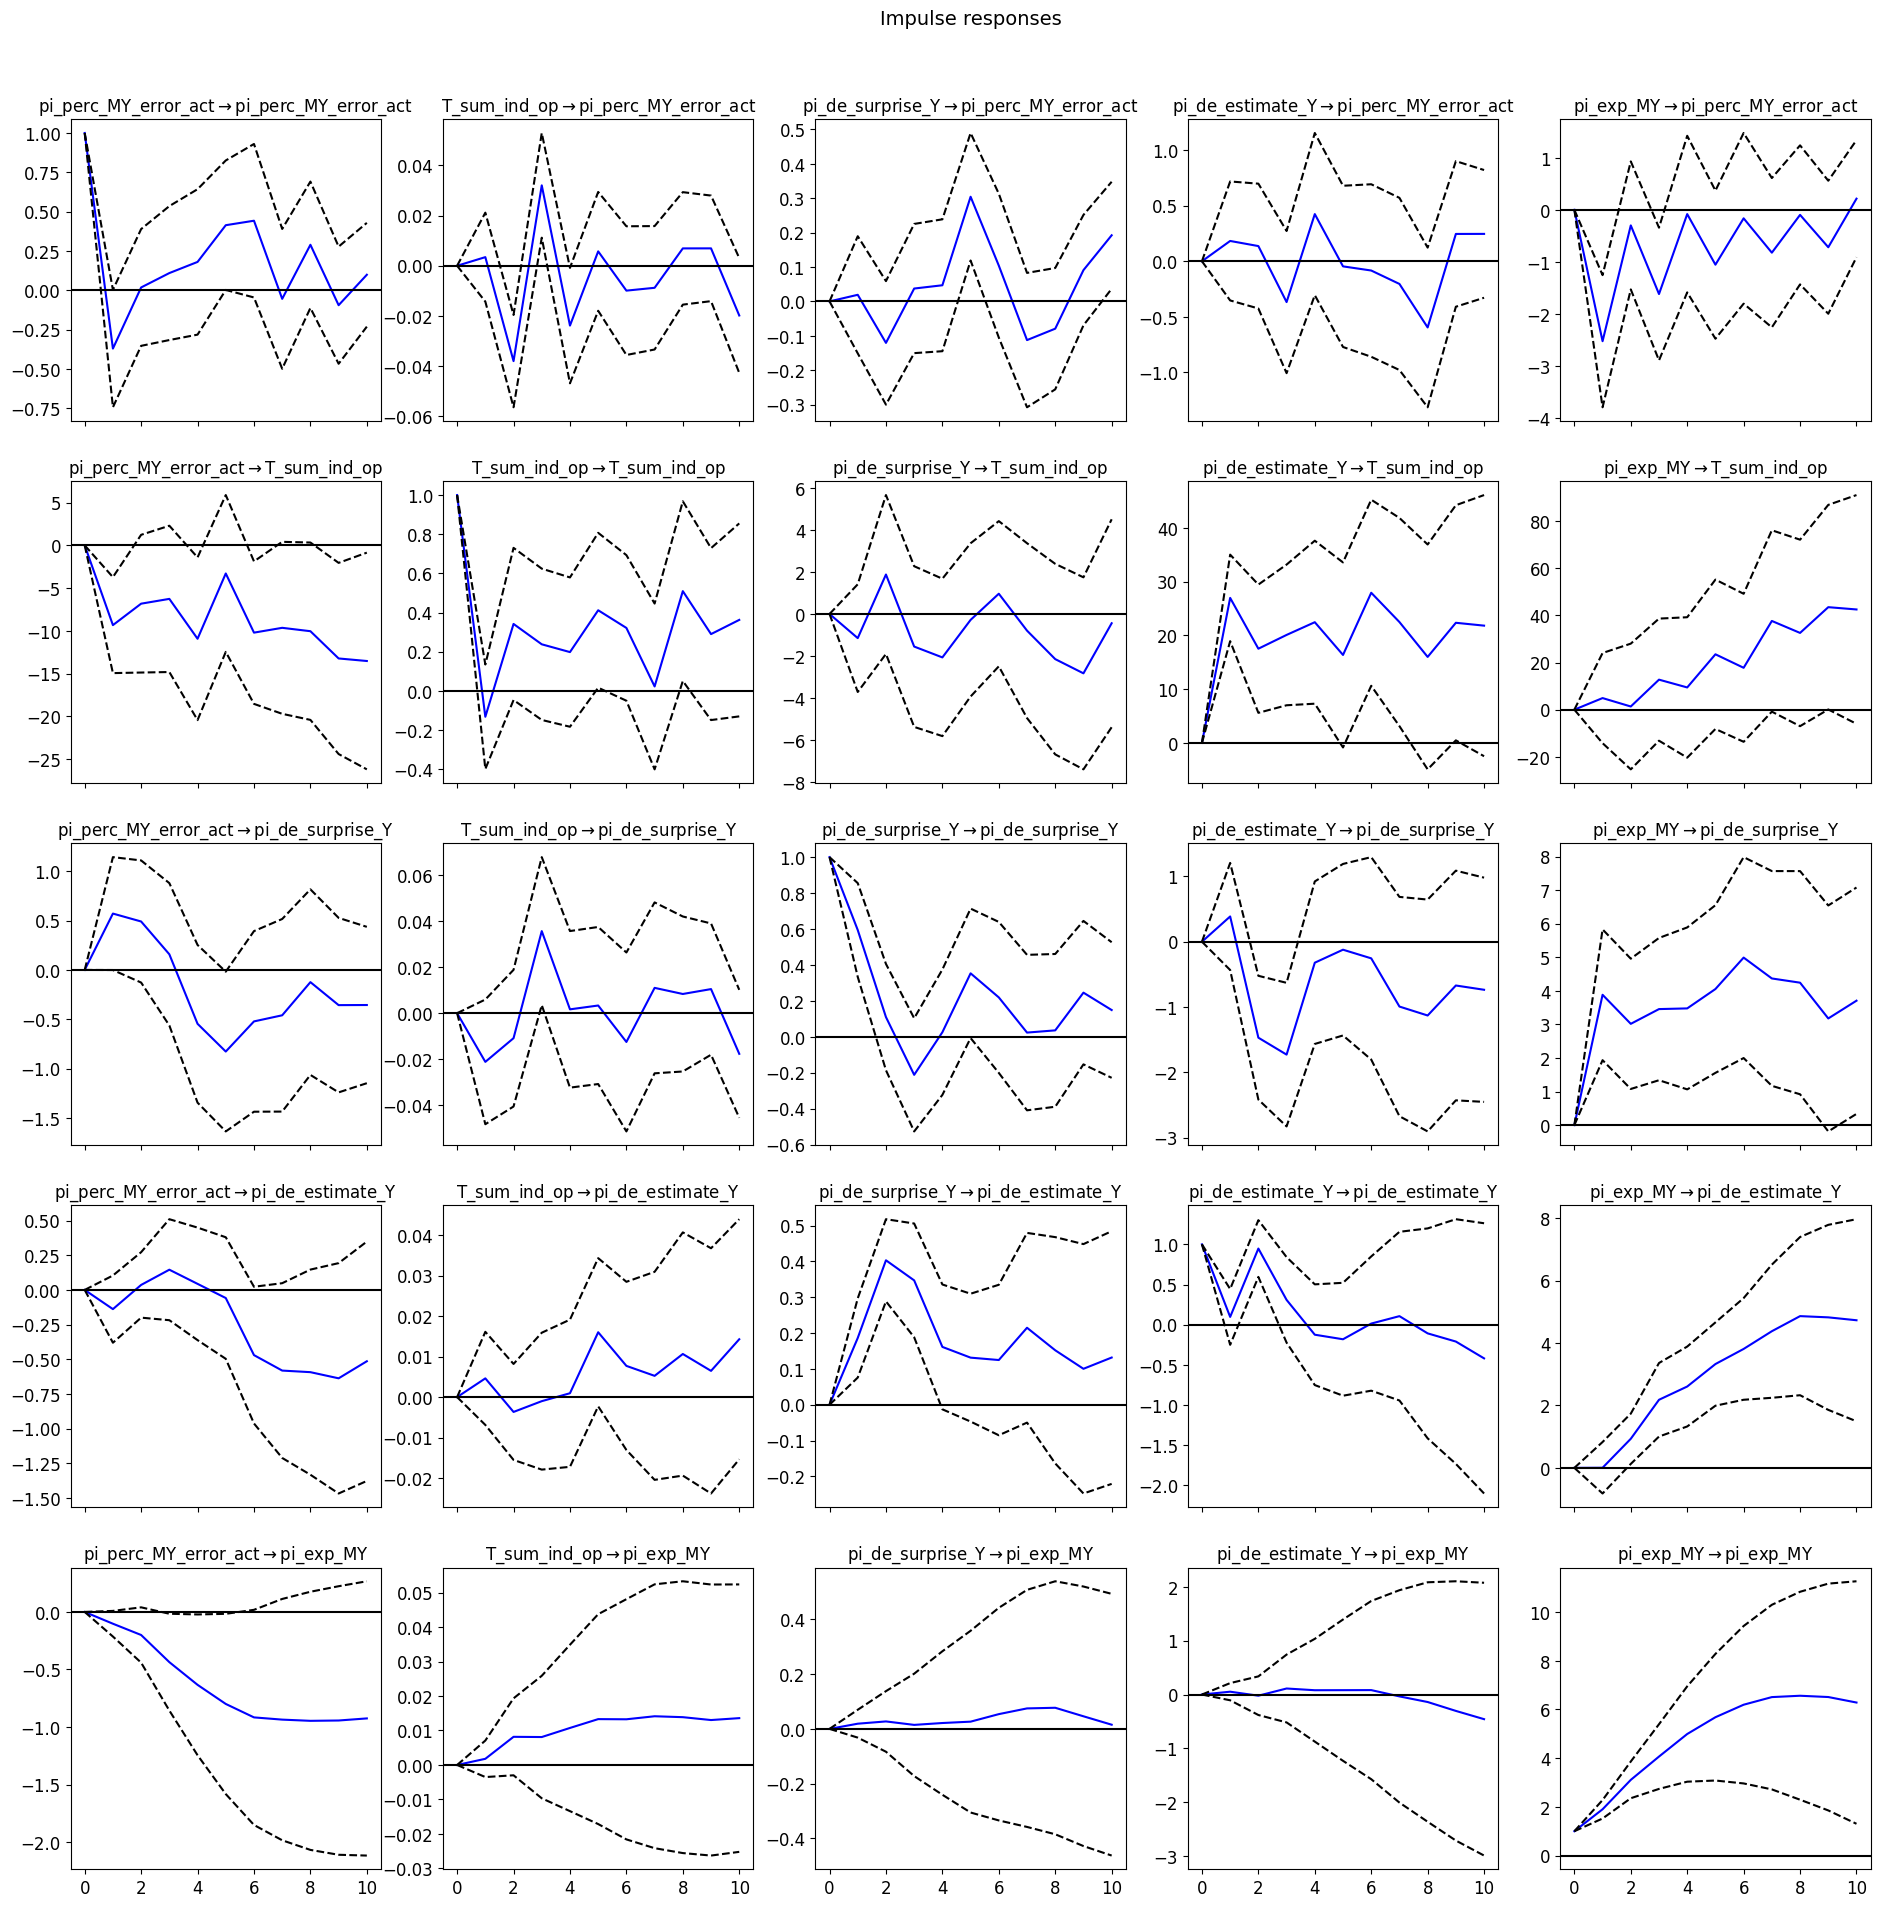

In [27]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY',]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm2.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_perc_resid.png');

### delta pe

delta_pe_MY ADF p-val: 0.5619457365131322
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_exp_MY ADF p-val: 0.14479079097337977
5
3 1


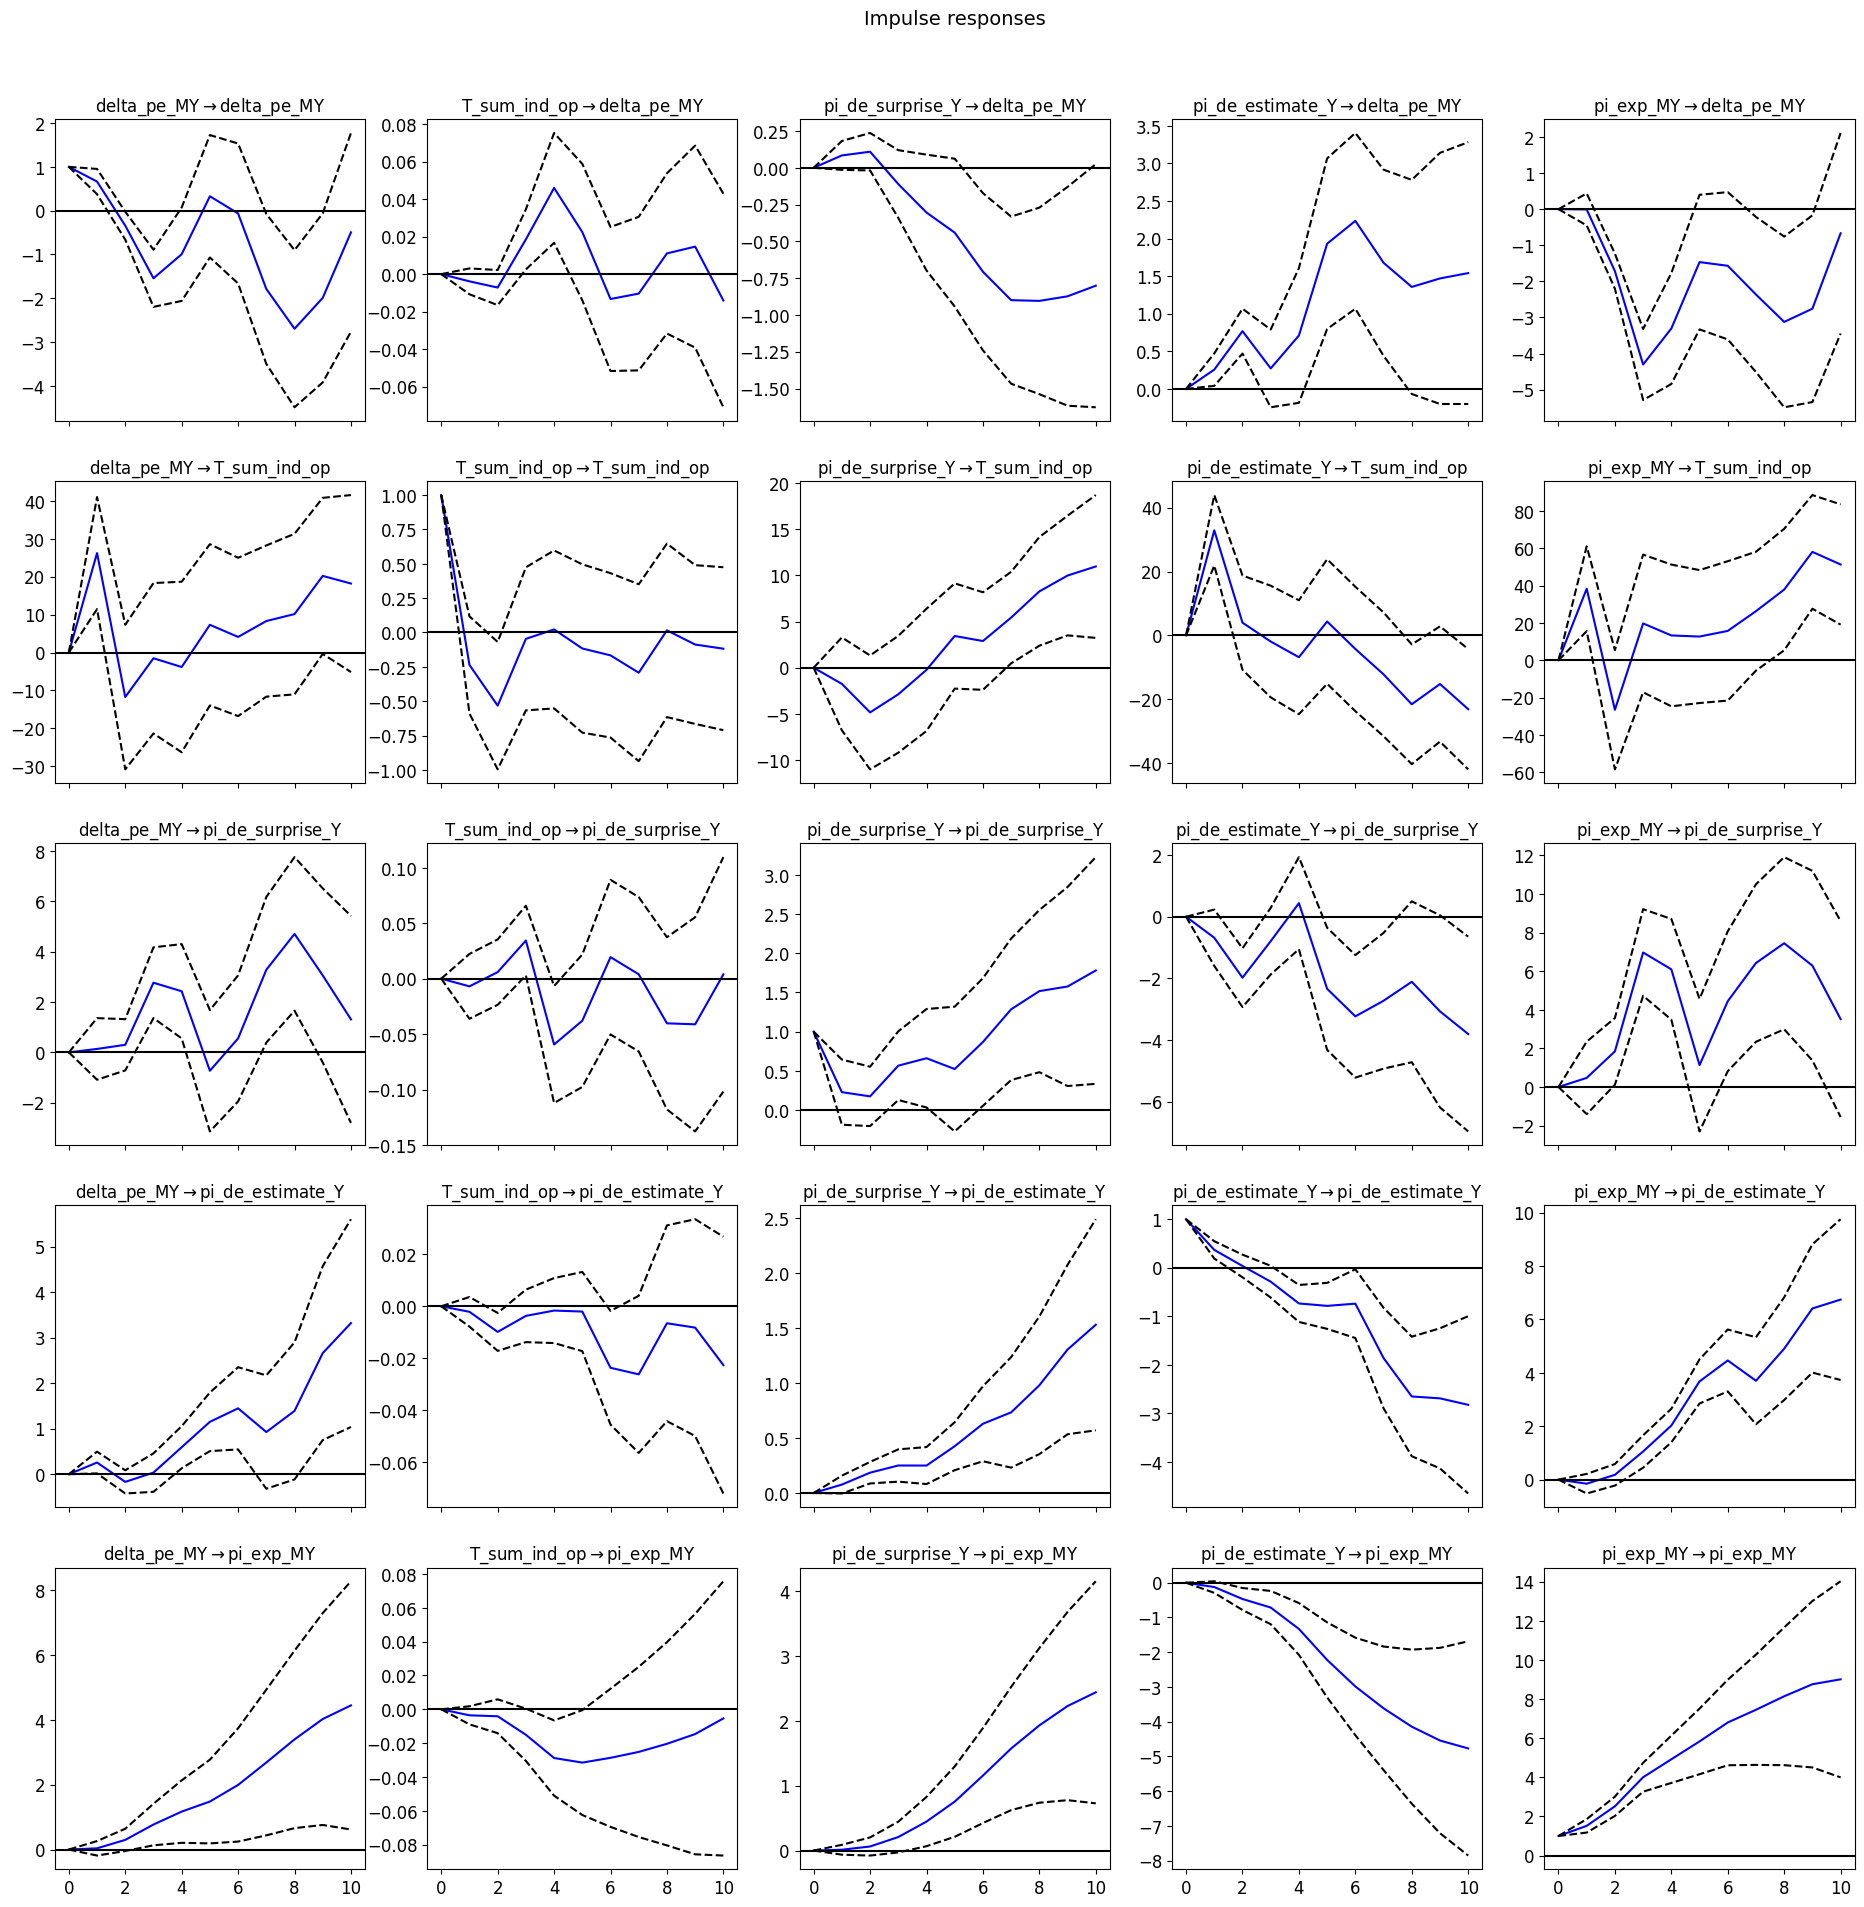

In [28]:
cols_endog, cols_exog = ['delta_pe_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm3.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_delta_pe.png');

### delta pe error

delta_pe_MY_error_act_MY ADF p-val: 0.5446227785790462
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y ADF p-val: 0.29697134223635535
pi_de_estimate_Y ADF p-val: 0.7775251260405094
pi_exp_MY ADF p-val: 0.2551156035612694
3
2 0


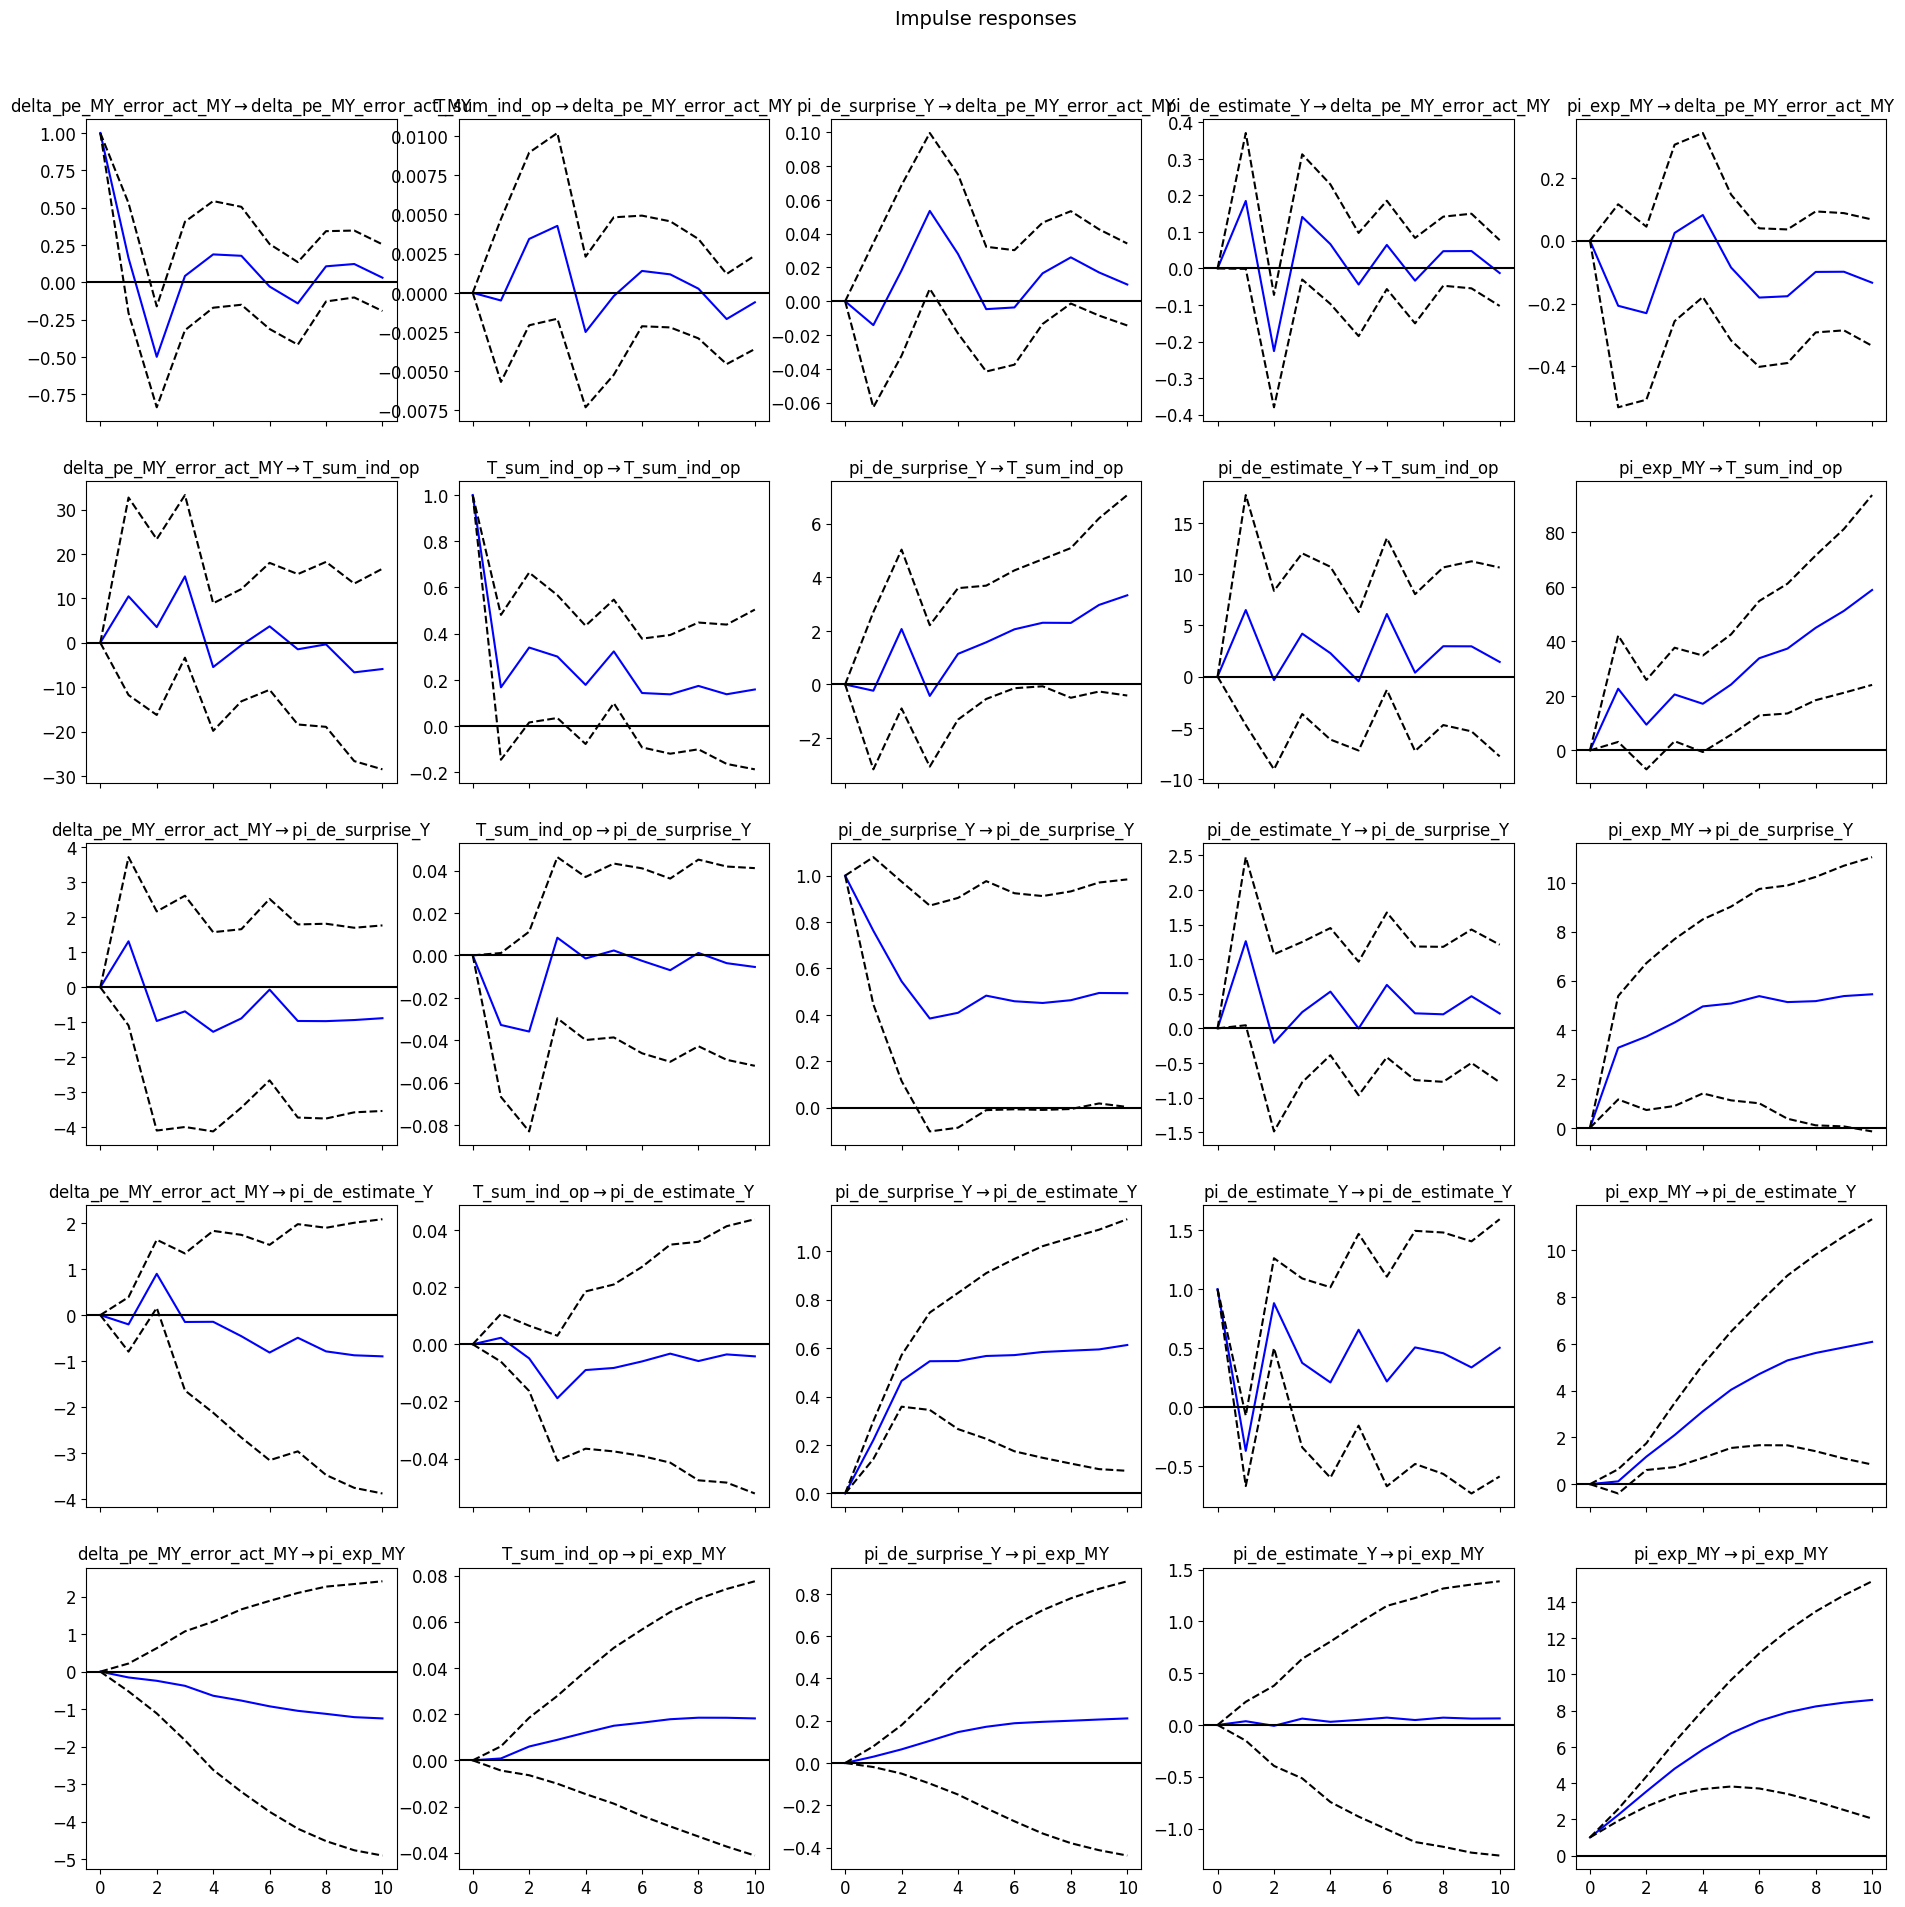

In [29]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm4.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_delta_pe_resid.png');

### pi perc S

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y_lead1 ADF p-val: 0.24946359680678376
pi_de_estimate_Y_lead1 ADF p-val: 0.7867507163884697
pi_exp_MY ADF p-val: 0.14479079097337977
4
3 3


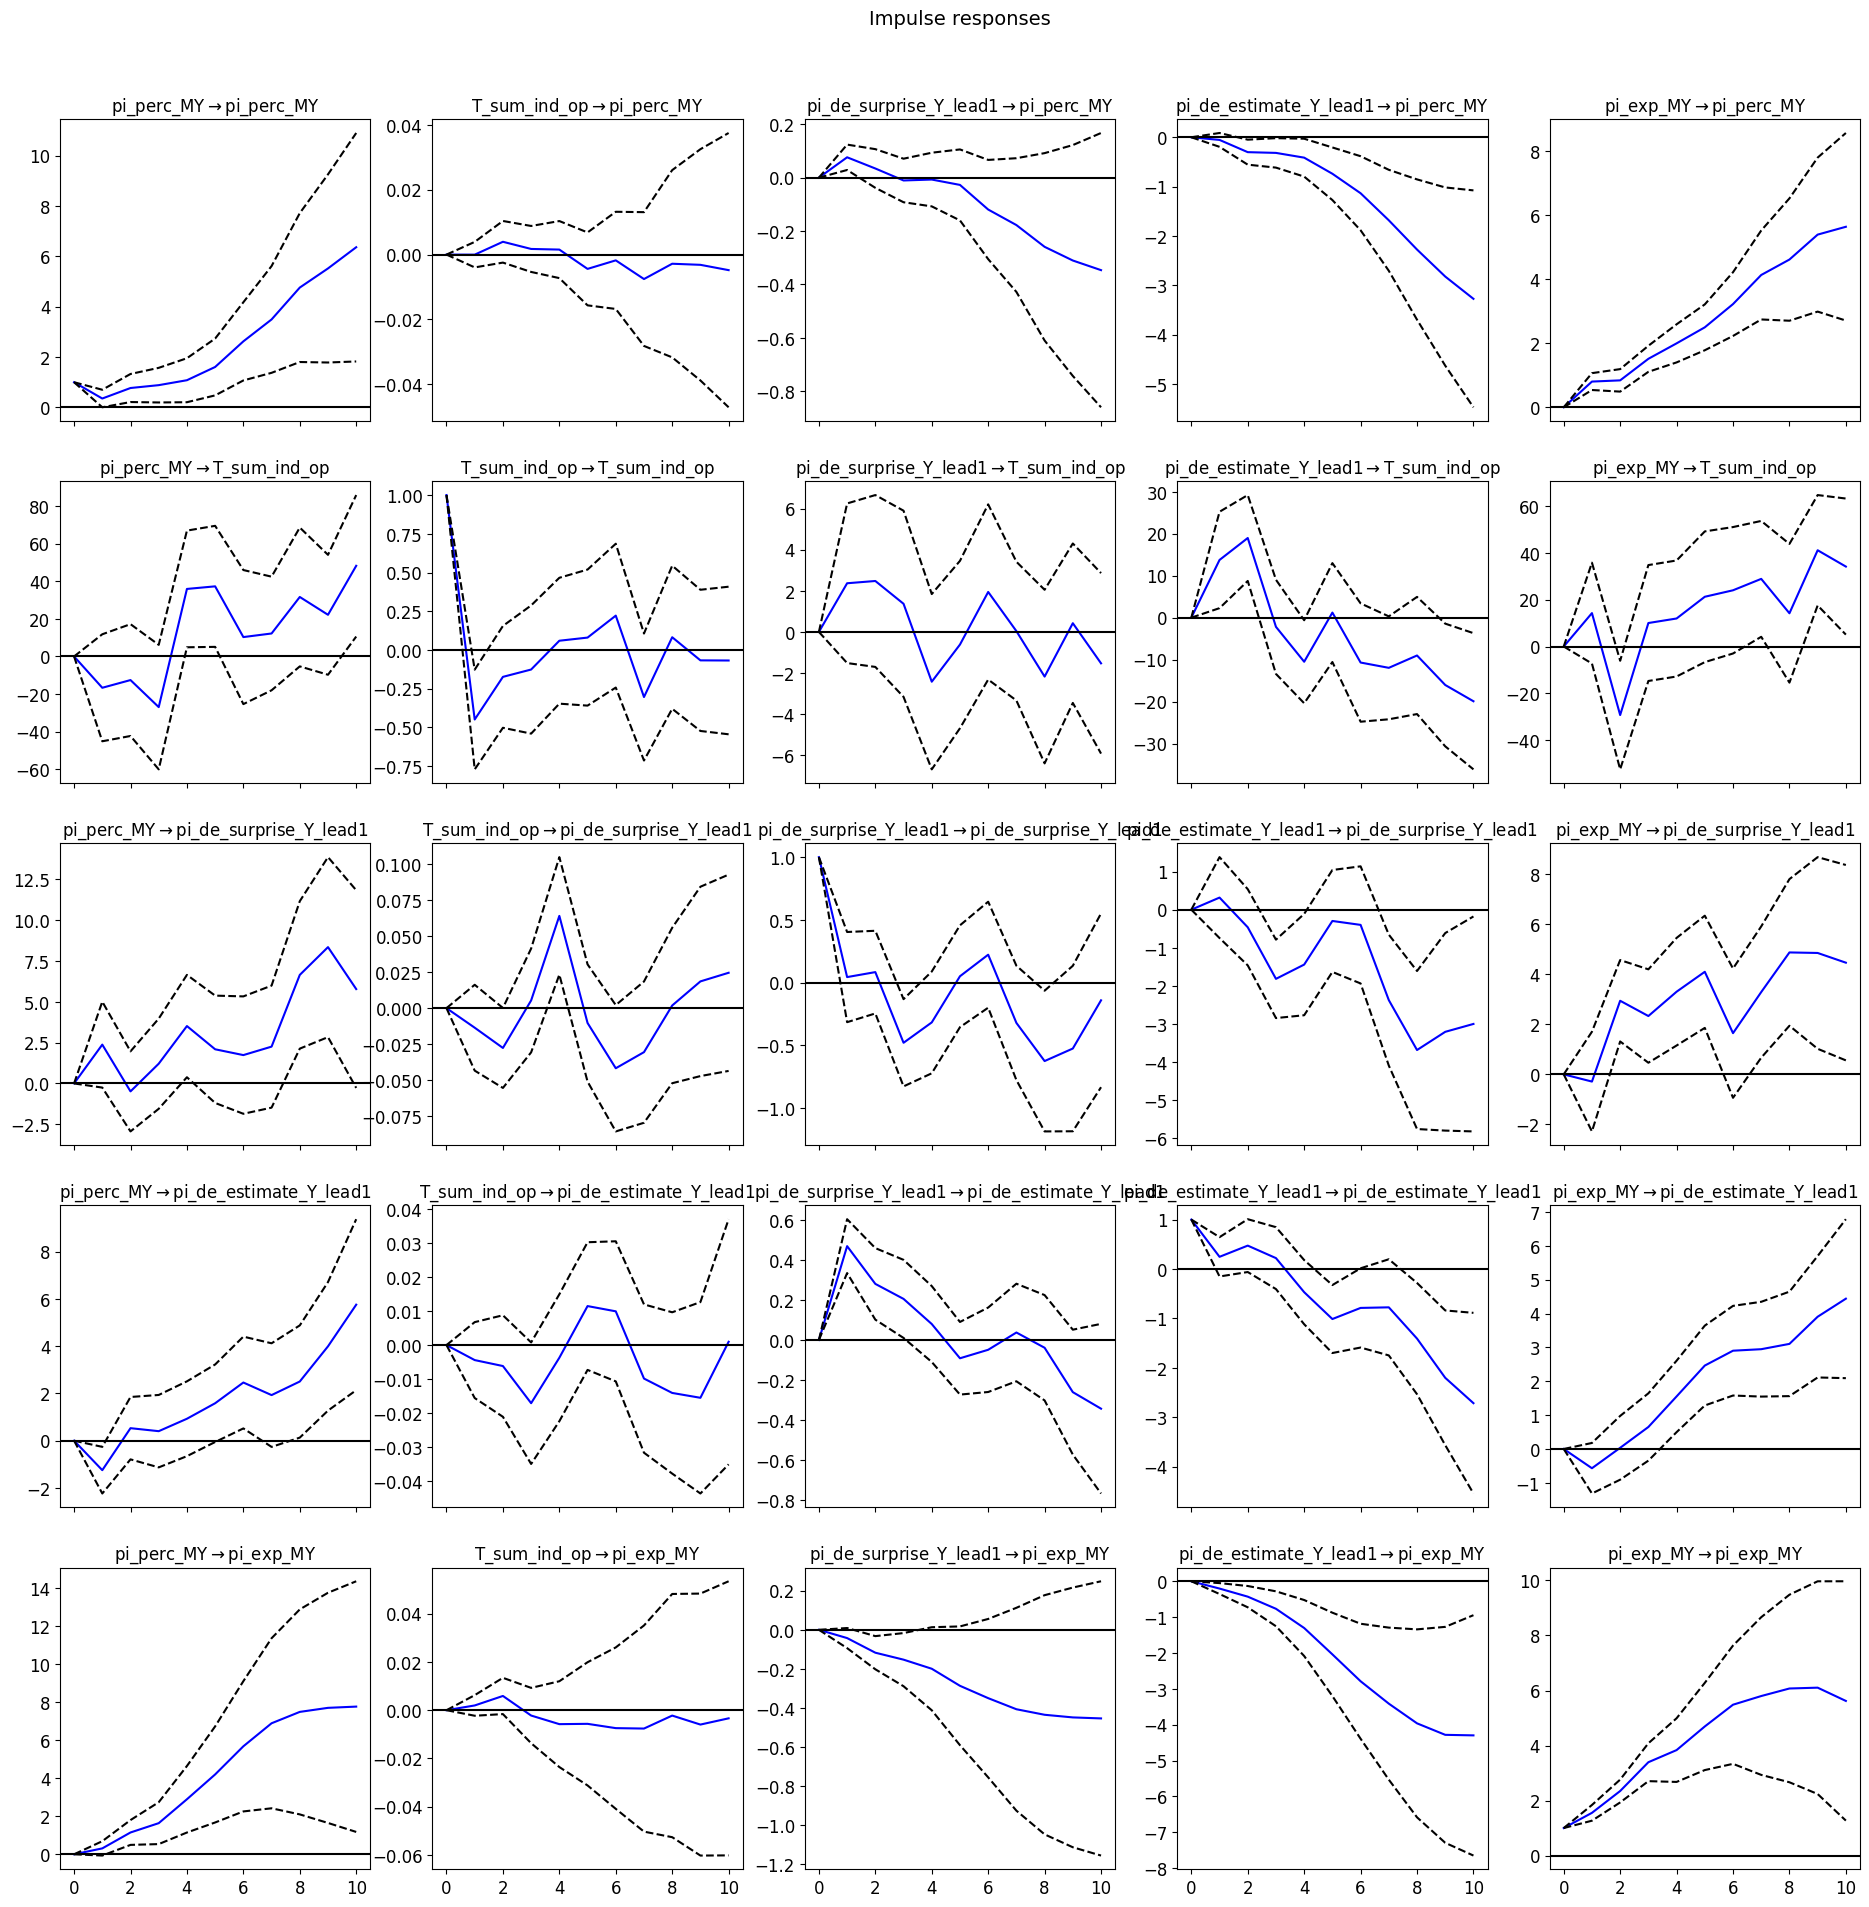

In [30]:
cols_endog, cols_exog = ['pi_perc_MY'], [t_sum_var, 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_exp_MY', ]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm5.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_percS.png');

### pi error S

pi_perc_MY_S_error_act ADF p-val: 5.314272487890989e-05
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y_lead1 ADF p-val: 0.40575633837933295
pi_de_estimate_Y_lead1 ADF p-val: 0.8003606318626139
pi_exp_MY ADF p-val: 0.2551156035612694
4
2 0


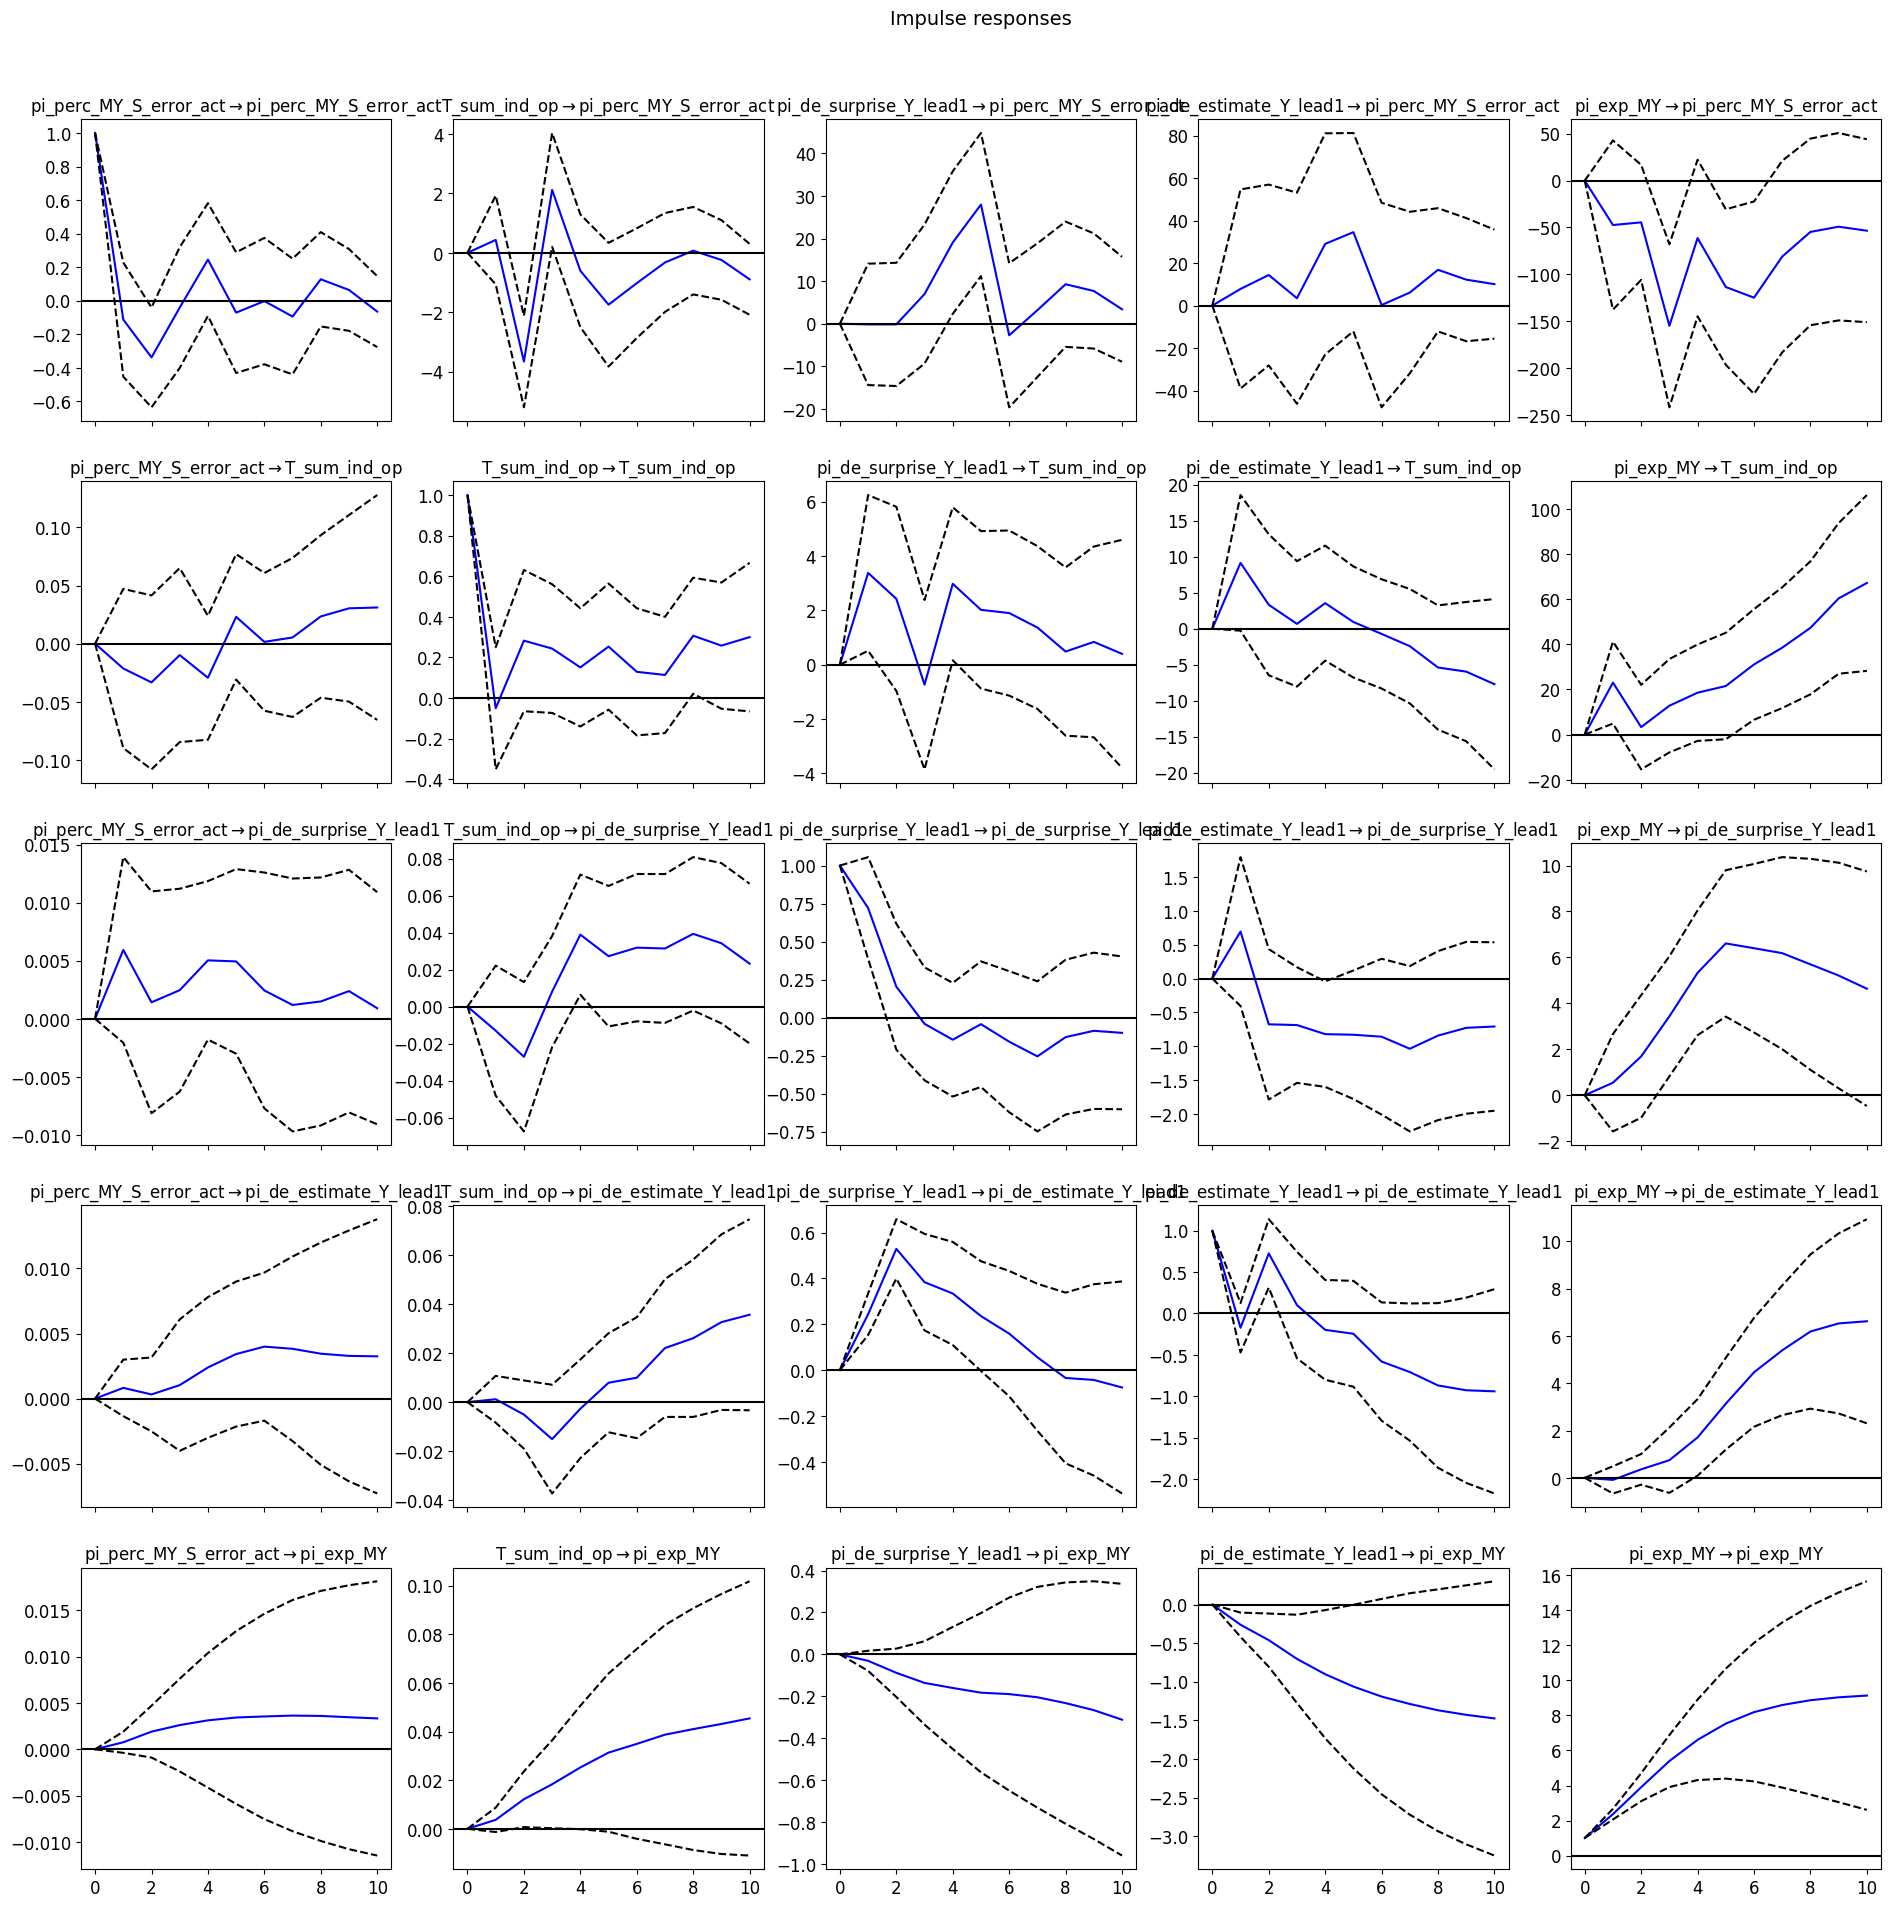

In [31]:
cols_endog, cols_exog = ['pi_perc_MY_S_error_act'], [t_sum_var, 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 4) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm6 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm6.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_perc_residS.png');

### summary

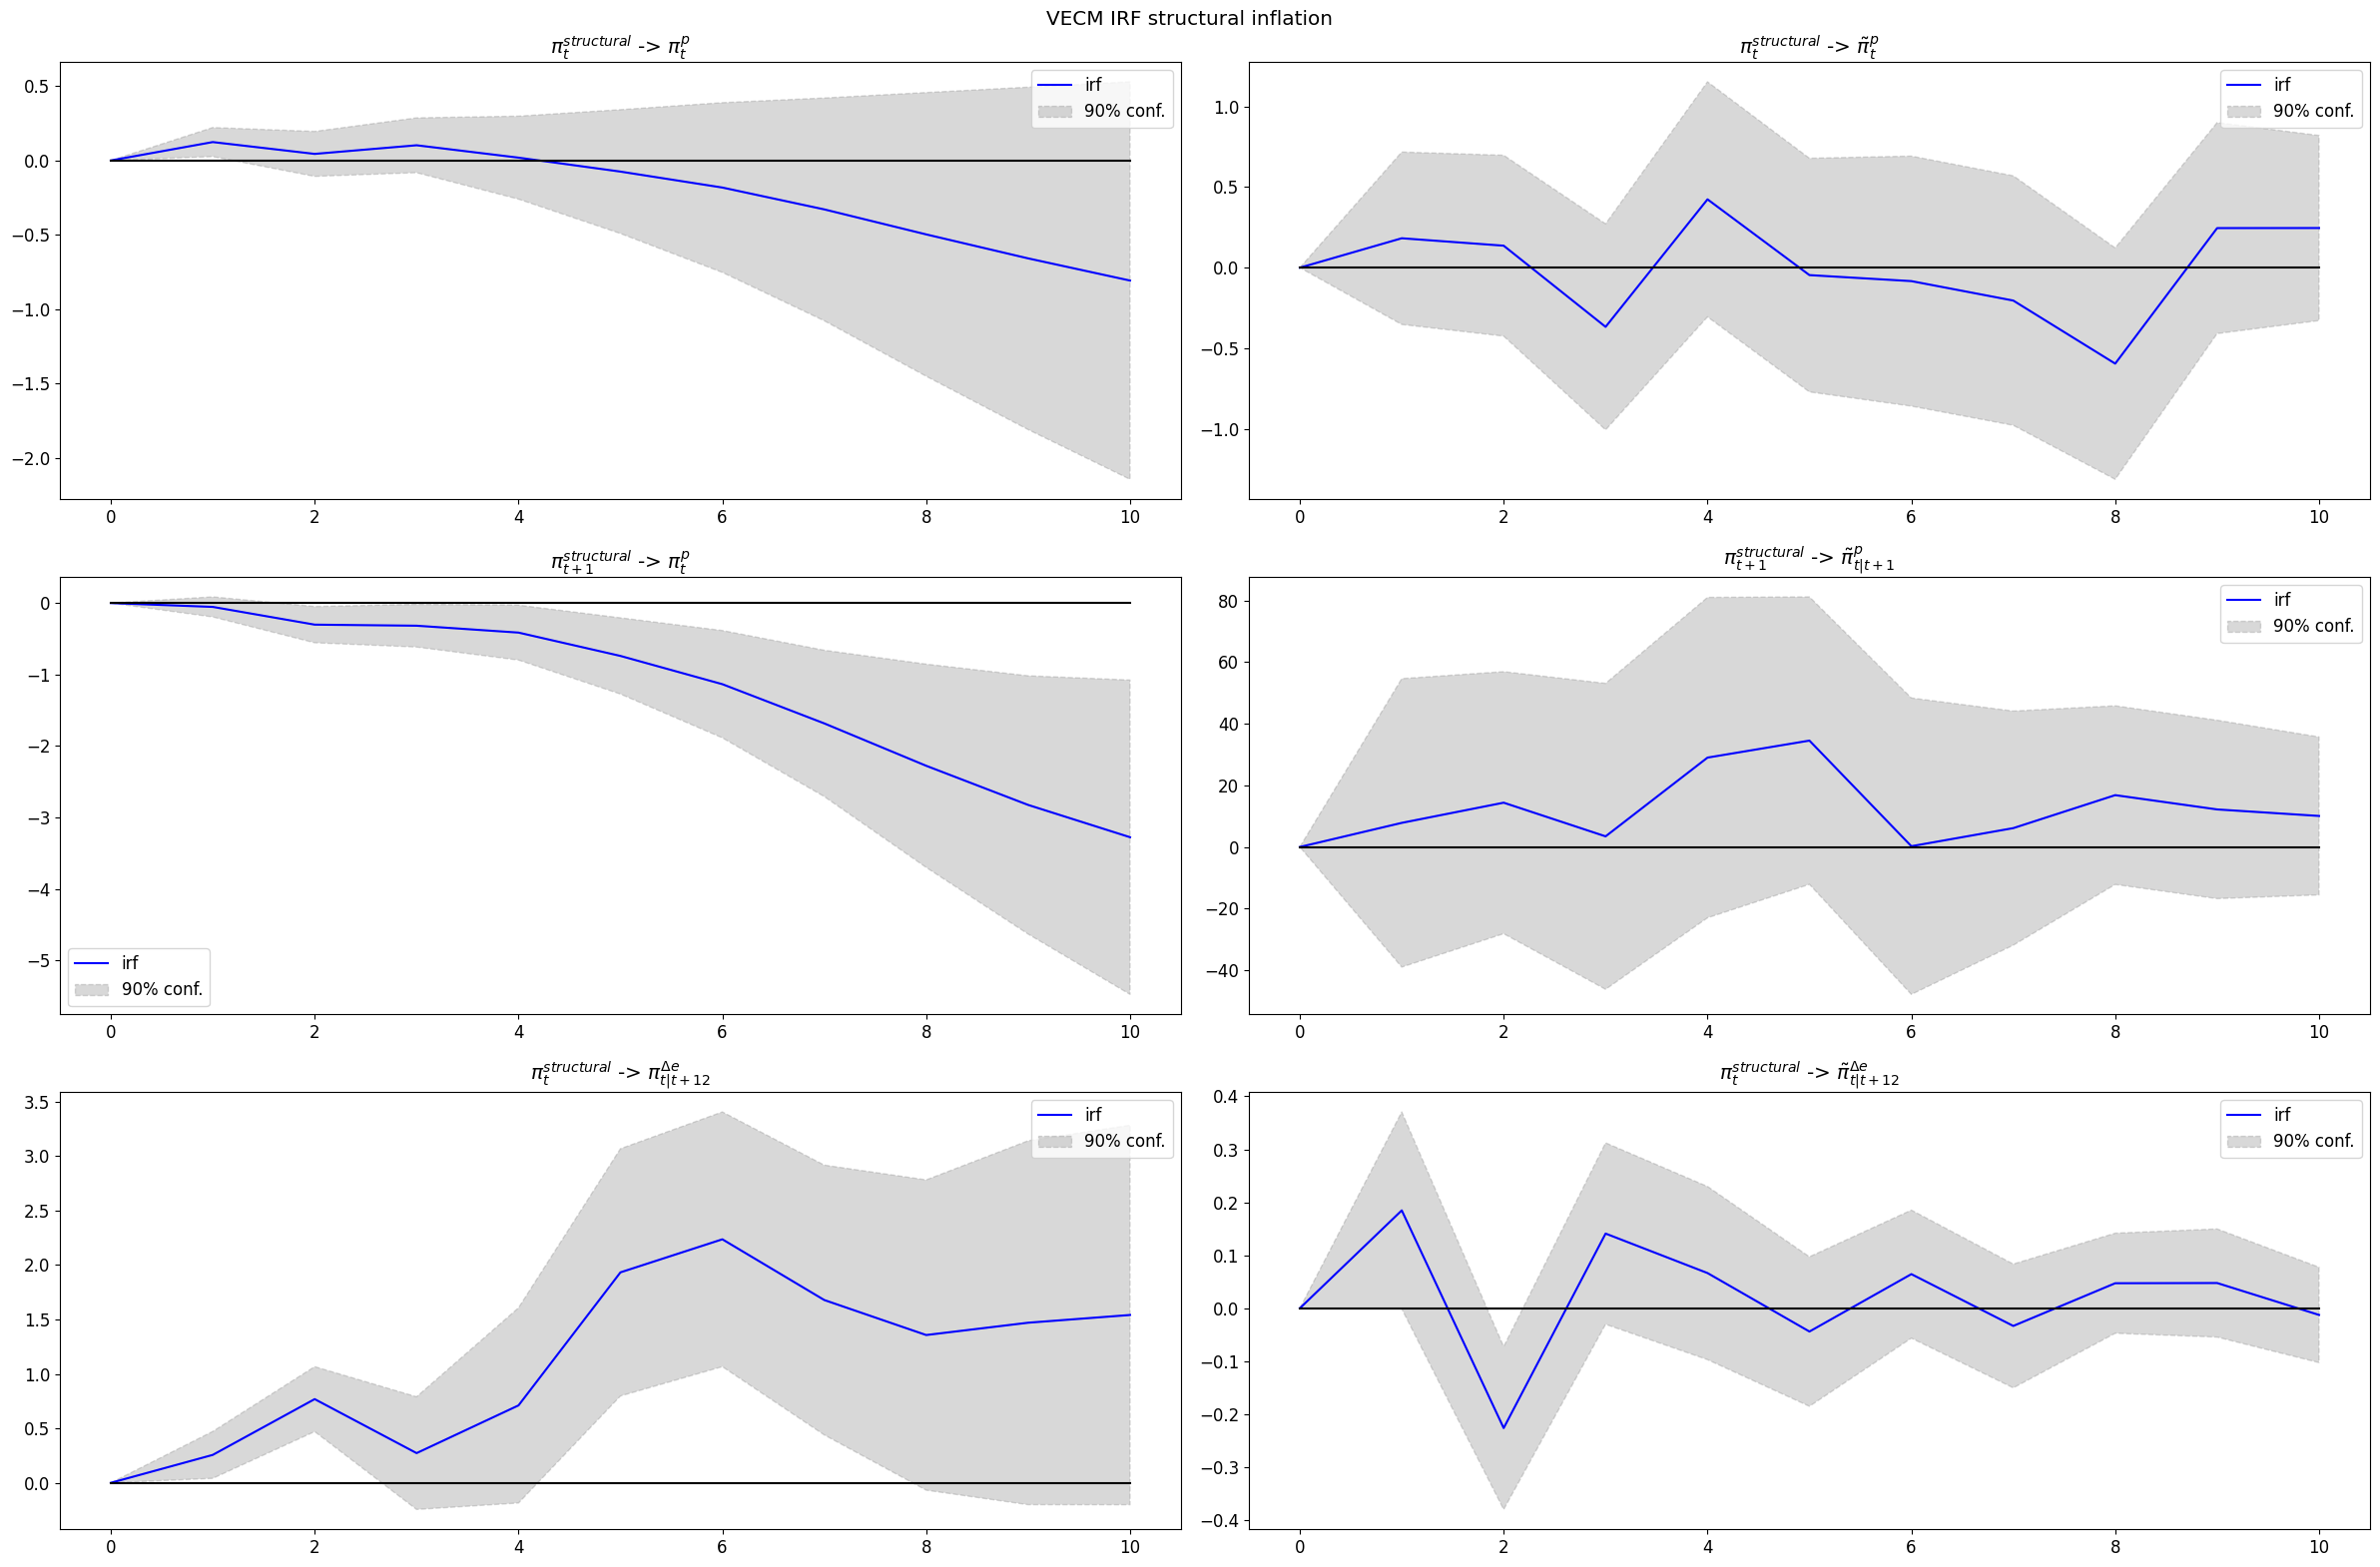

In [129]:
lst_vecms = [vecm1, vecm2, vecm5, vecm6, vecm3, vecm4]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_de_estimate_Y": "$\pi^{structural}_t$",
                                          "pi_de_estimate_Y_lead1": "$\pi^{structural}_{t+1}$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t|t+1}$",
                                         },
                             idx_vecm=(0, 3),
                             n_cols=2,
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF structural inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_struct.png")

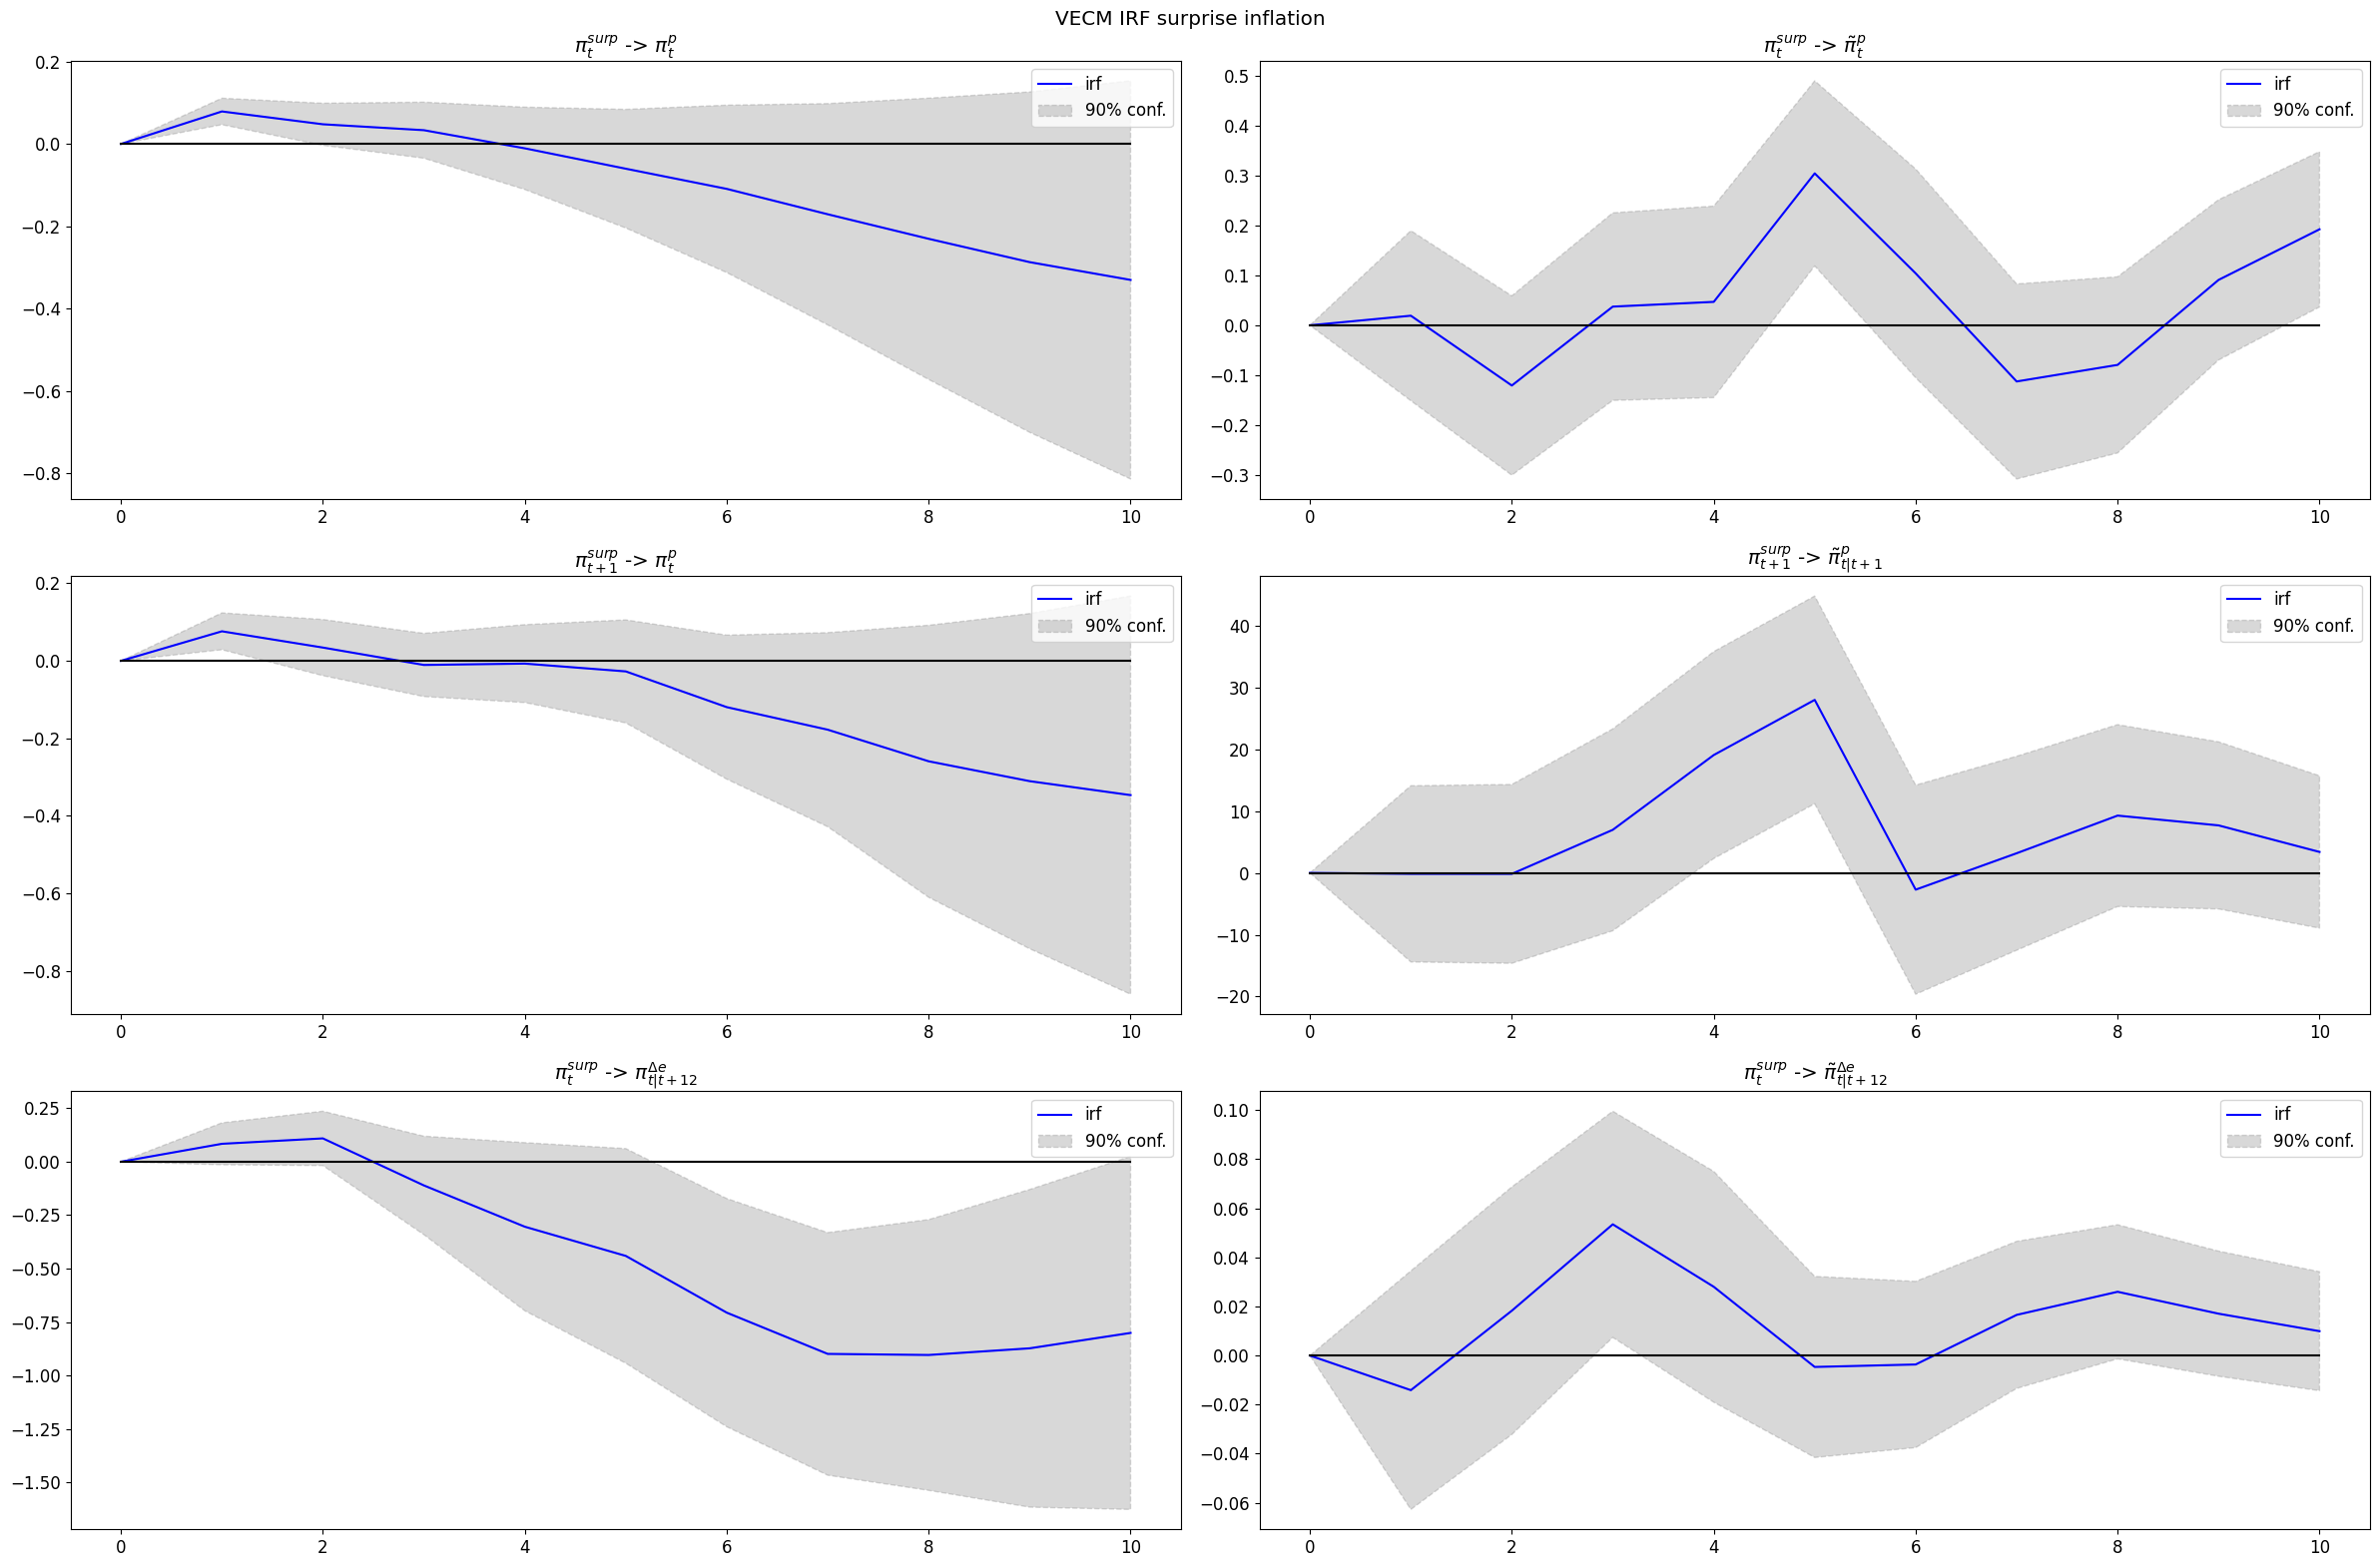

In [130]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "pi_de_surprise_Y_lead1": "$\pi^{surp}_{t+1}$",
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t|t+1}$",
                                         },
                             idx_vecm=(0,2),
                             n_cols=2, 
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_surp.png", GRAPHS_DIR)

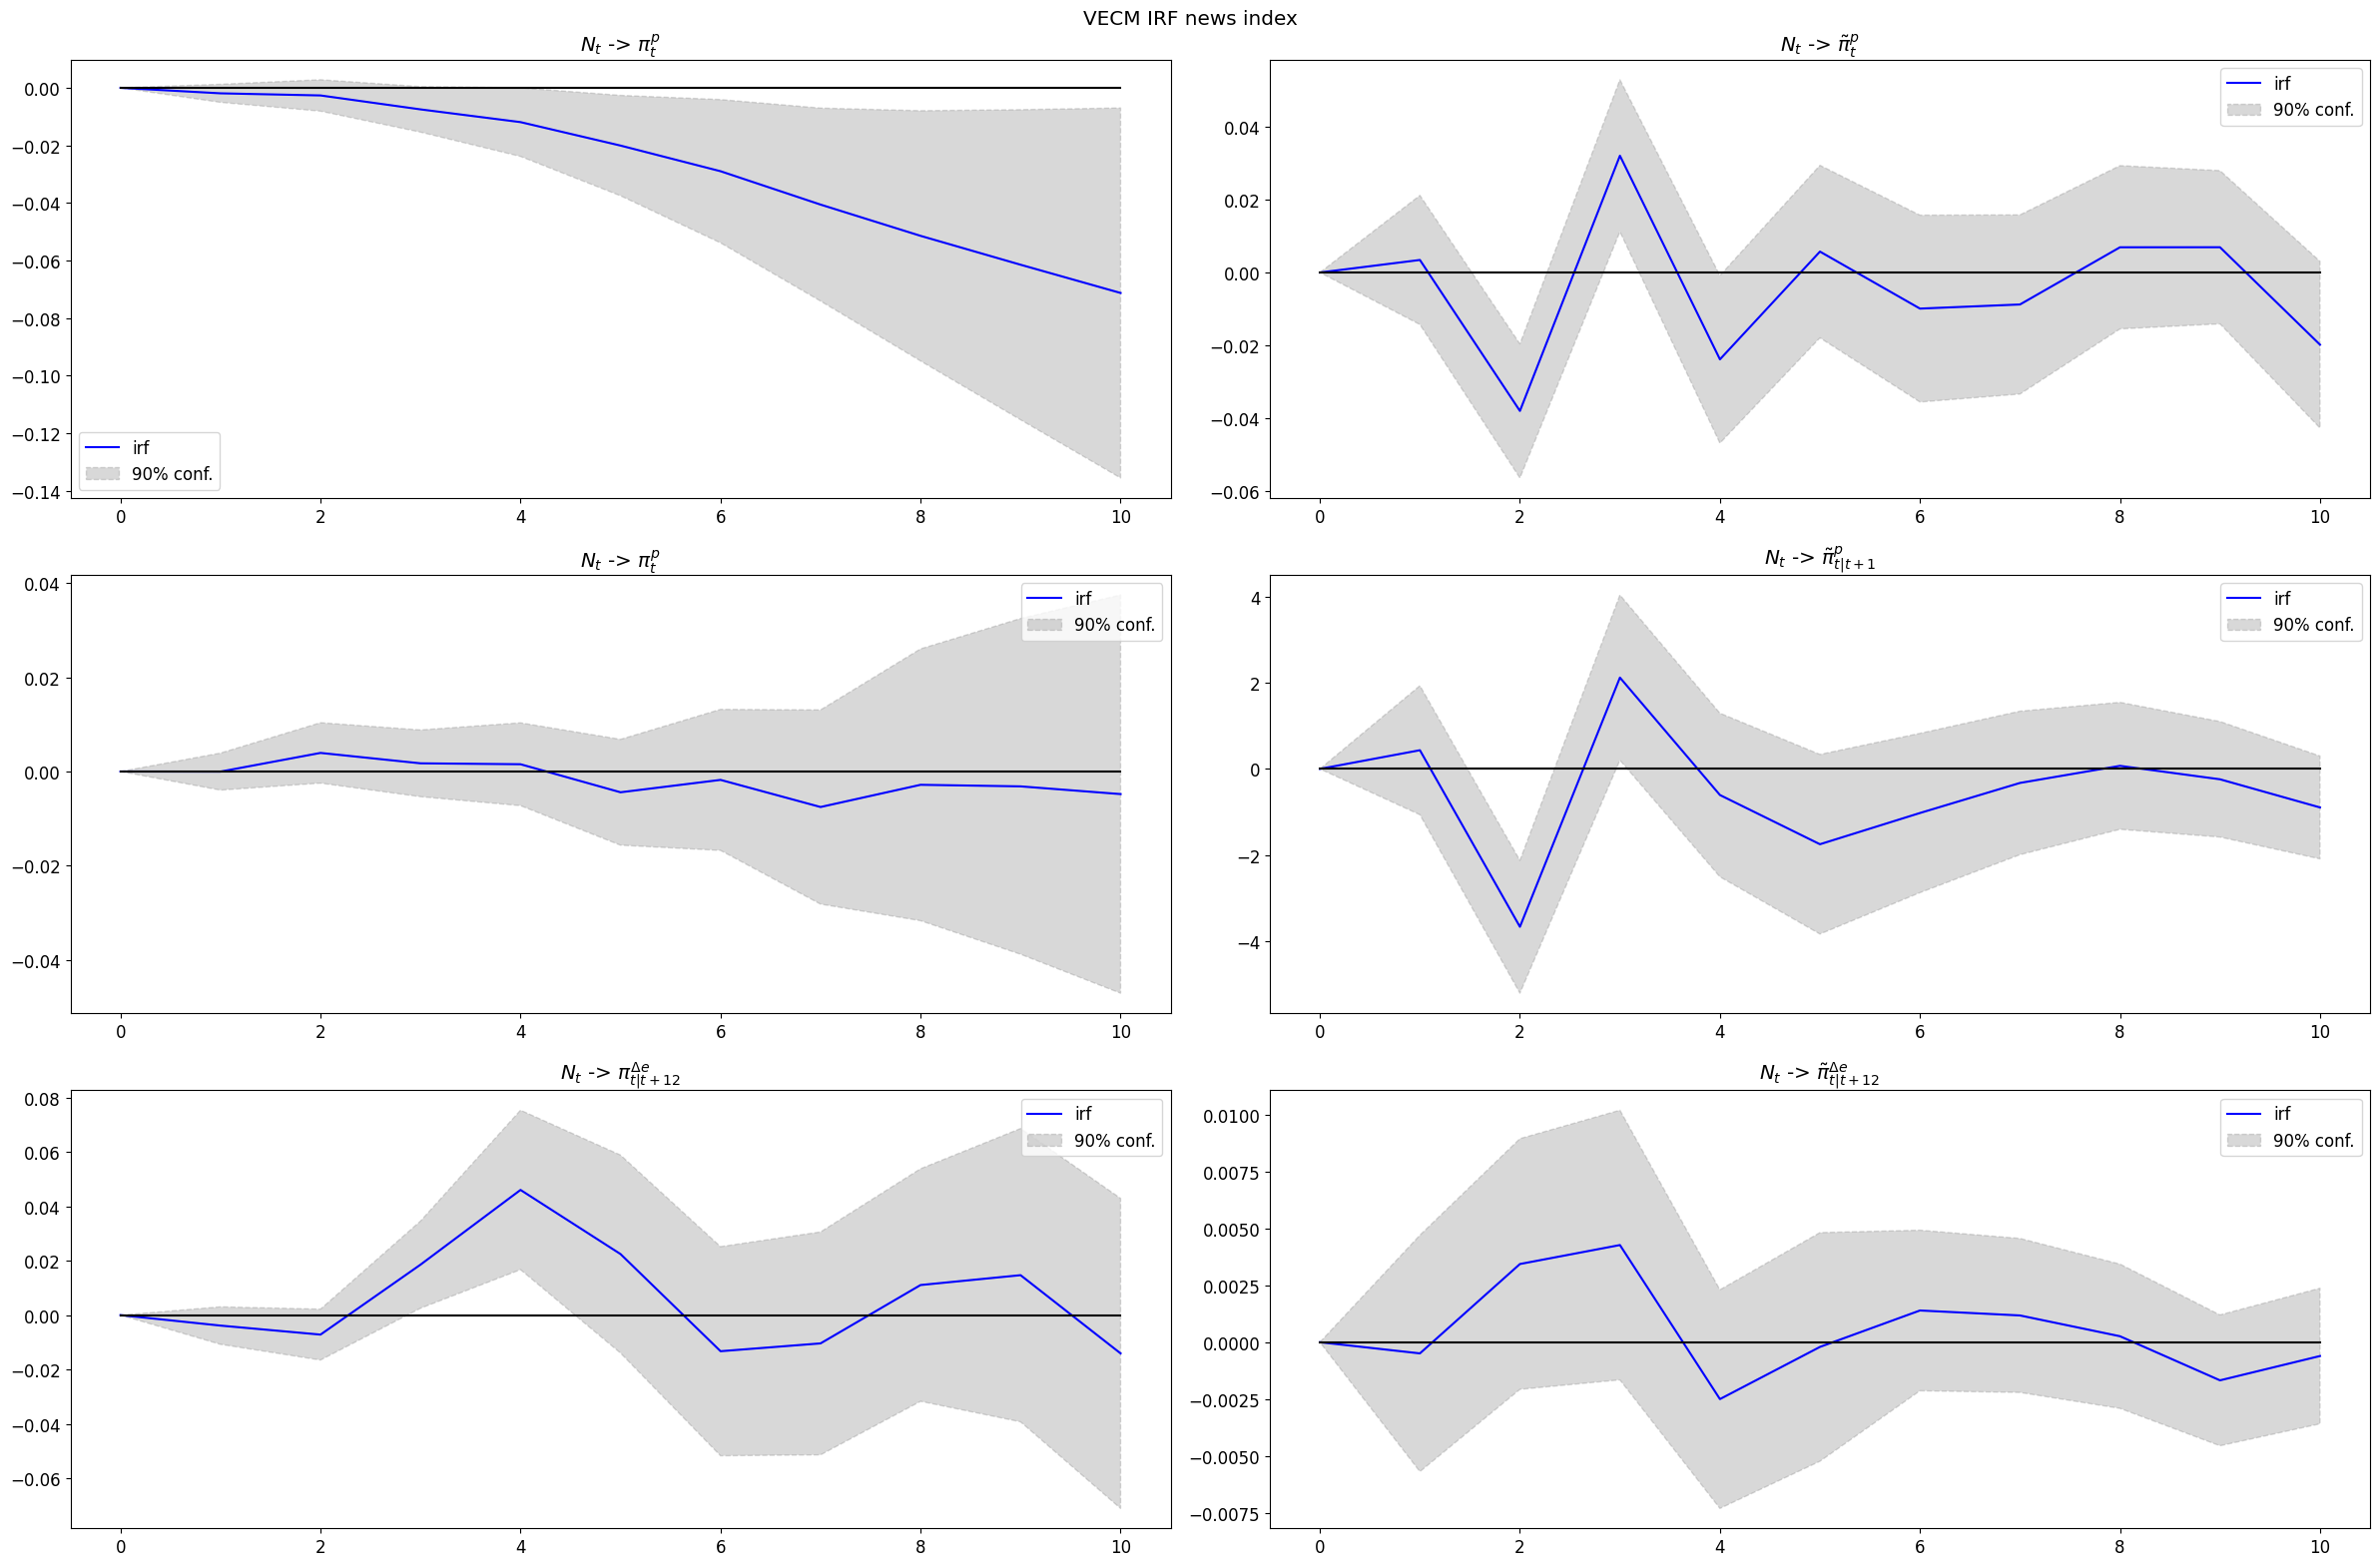

In [131]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum_ind_op": "$N_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t|t+1}$",
                                         },
                             n_cols=2,
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF news index")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news.png")

## investigate seasonality

In [74]:
sub = df.groupby('week_recorded')[['pi_perc_WY', 'pi_exp_WY', 'T_sum_ind_op']].mean().diff()

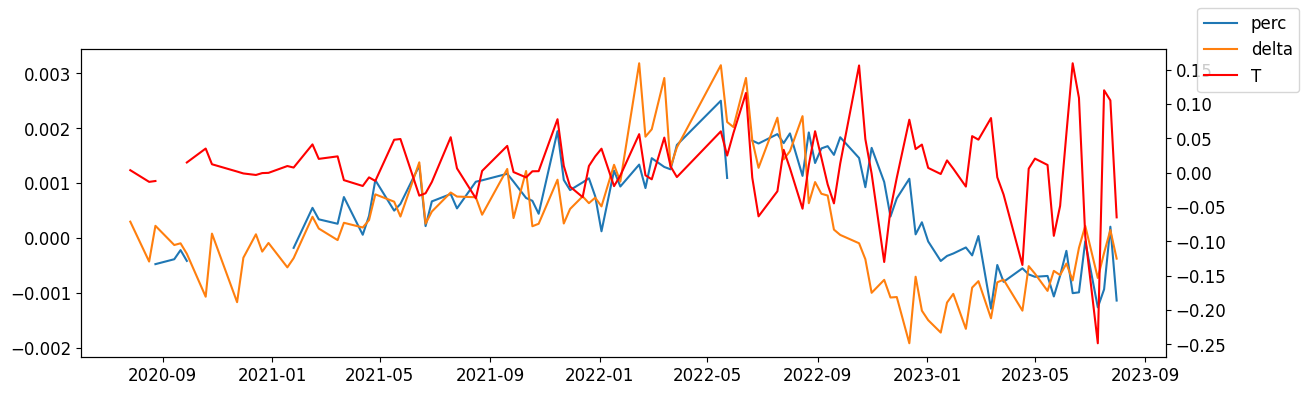

In [75]:
fig, ax = get_fig_subplots()
ax.plot(sub.pi_perc_WY)
ax.plot(sub.pi_exp_WY)
ax.twinx().plot(sub.T_sum_ind_op, color='red')
fig.legend(['perc', 'delta', 'T'])

In [76]:
sub = sub.dropna()

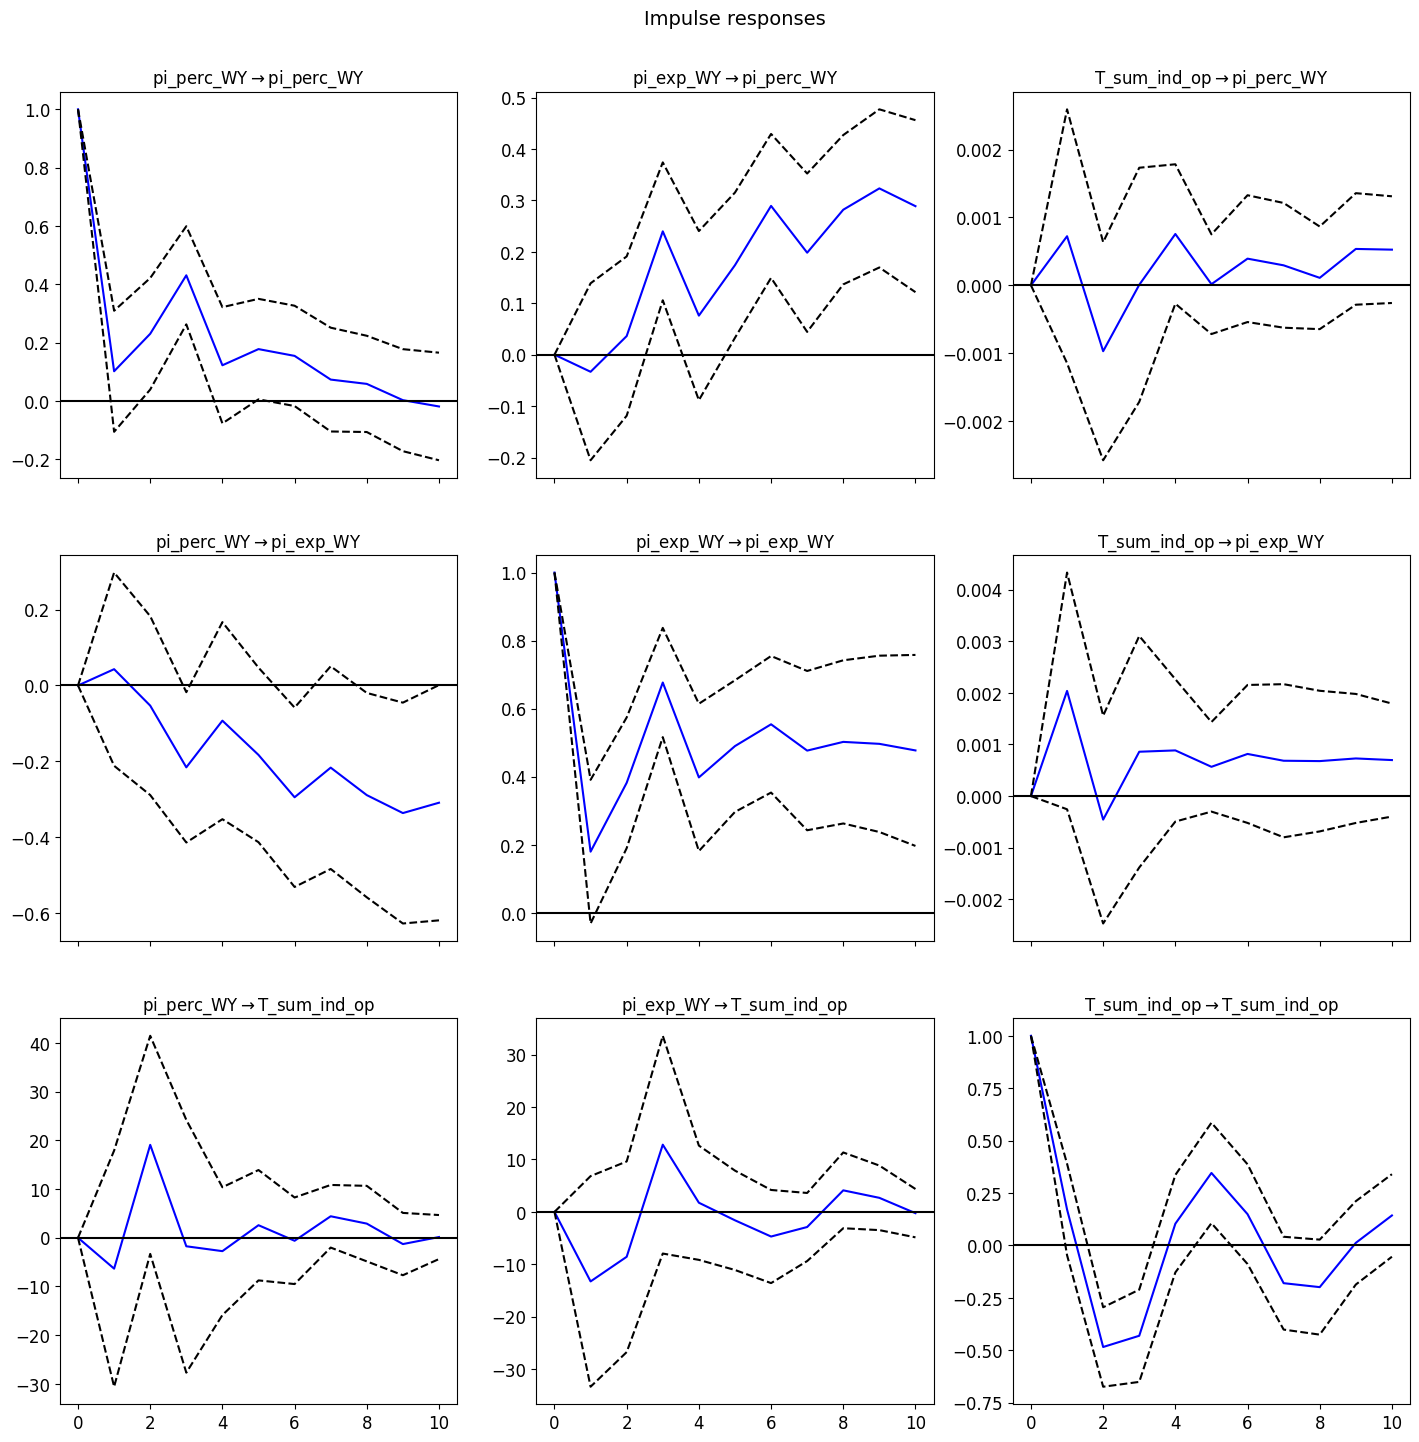

In [81]:
var = VAR(sub).fit(ic='aic')
var.irf().plot(figsize=(15,15));

In [78]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub, -1, 8) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub.diff().dropna(), maxlags=8)
print(var_order.aic, var_order.bic)

vecm = VECM(sub.dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_WY ADF p-val: 0.7819415029424195
pi_exp_WY ADF p-val: 0.1615296448584021
T_sum_ind_op ADF p-val: 6.780921012856412e-07
2
2 2


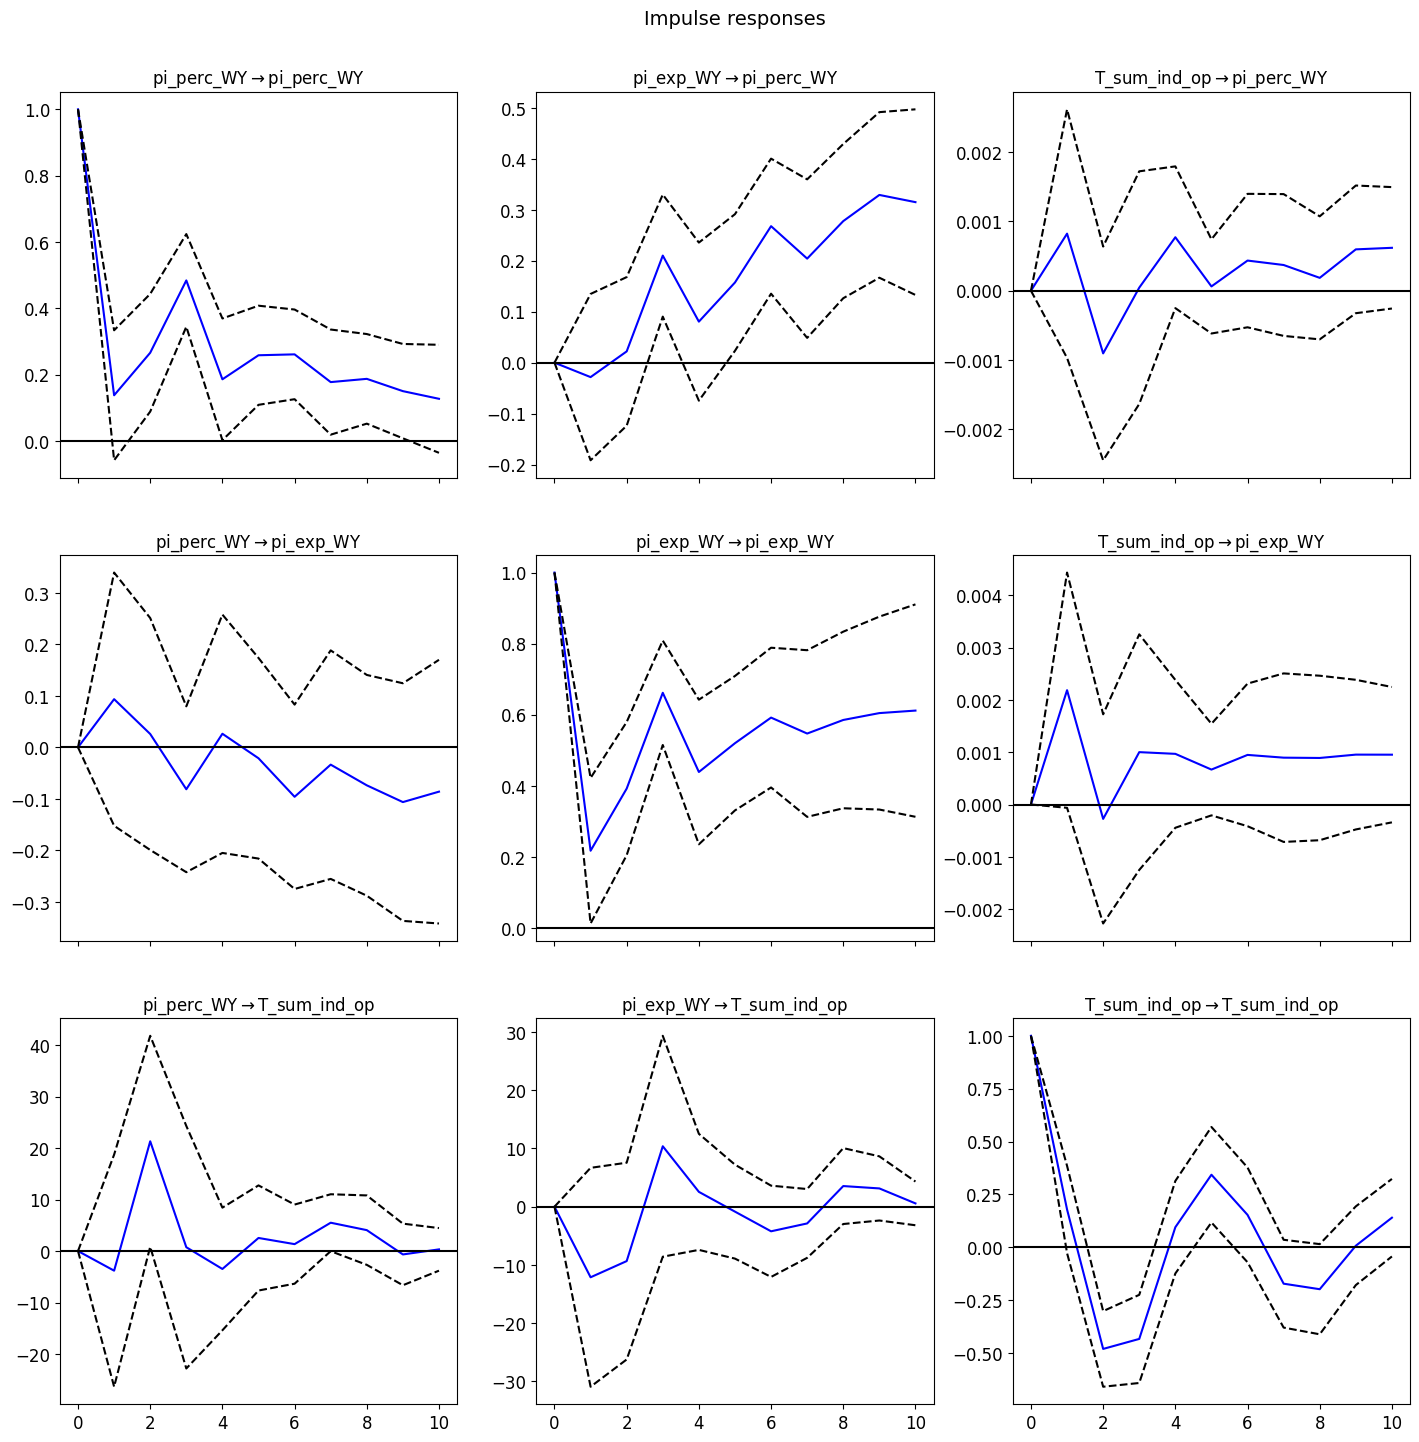

In [80]:
vecm.irf().plot(figsize=(15,15));

## output

In [48]:
out = get_statsmodels_summary(lst_vecms, seperator=" ", is_filt_sig=True)
save_pd_df(out, 'tab_vecm_news_resid.csv', GRAPHS_DIR)

In [49]:
out

delta_pe_MY delta_pe_MY_error_act_MY  \
L2.pi_de_surprise_Y            0.3892 *** [3.319]        -0.0089  [-0.188]   
L3.pi_de_surprise_Y              0.146 ** [2.391]                      NaN   
L3.pi_de_estimate_Y_lead1                     NaN                      NaN   
L3.delta_pe_MY                -0.3204 ** [-2.427]                      NaN   
L3.T_sum_ind_op              -0.0194 *** [-4.768]                      NaN   
L2.pi_perc_MY_error_act                       NaN                      NaN   
L2.pi_exp_MY                  -1.083 *** [-3.724]           0.181  [1.023]   
L2.pi_de_surprise_Y_lead1                     NaN                      NaN   
L2.pi_de_estimate_Y_lead1                     NaN                      NaN   
L3.pi_de_surprise_Y_lead1                     NaN                      NaN   
L2.delta_pe_MY                  0.5196 *** [2.79]                      NaN   
L1.pi_perc_MY_error_act                       NaN                      NaN   
L1.pi_exp_MY                     0.4722 * [1.775]        -0.1212  [-0.774]   
L1.pi_de_surprise_Y_lead1                     NaN                      NaN   
L1.pi_de_surprise_Y            0.3812 *** [3.047]        -0.0056  [-0.098]   
L1.pi_de_estimate_Y          -0.5449 *** [-4.357]         0.1414 ** [2.31]   
L1.delta_pe_MY_error_act_MY                   NaN       0.5332 *** [2.785]   
L1.delta_pe_MY                 1.2789 *** [8.246]                      NaN   
L1.T_sum_ind_op              -0.0303 *** [-6.536]     -0.0077 *** [-2.696]   
L2.T_sum_ind_op              -0.0347 *** [-8.524]        -0.0048  [-1.541]   
L3.pi_exp_MY                 -1.9025 *** [-4.835]                      NaN   
N lags                                          4                        3   
Coint. rank                                     5                        3   
Normality                       True *** [18.307]           True  [18.307]   
N                                              30                       33   
Whiteness                     False *** [179.581]          True  [217.735]   

                                     pi_perc_MY          pi_perc_MY_2  \
L2.pi_de_surprise_Y            -0.013  [-0.486]                   NaN   
L3.pi_de_surprise_Y                         NaN                   NaN   
L3.pi_de_estimate_Y_lead1                   NaN  -0.1753 *** [-3.482]   
L3.delta_pe_MY                              NaN                   NaN   
L3.T_sum_ind_op                             NaN   -0.008 *** [-3.812]   
L2.pi_perc_MY_error_act                     NaN                   NaN   
L2.pi_exp_MY                 -0.2573 ** [-2.14]    -0.3428 * [-1.674]   
L2.pi_de_surprise_Y_lead1                   NaN  -0.1995 *** [-3.475]   
L2.pi_de_estimate_Y_lead1                   NaN   -0.205 *** [-3.321]   
L3.pi_de_surprise_Y_lead1                   NaN  -0.1093 *** [-3.263]   
L2.delta_pe_MY                              NaN                   NaN   
L1.pi_perc_MY_error_act                     NaN                   NaN   
L1.pi_exp_MY                 0.3004 *** [3.453]    0.3556 *** [3.008]   
L1.pi_de_surprise_Y_lead1                   NaN  -0.2628 *** [-3.209]   
L1.pi_de_surprise_Y             0.0049  [0.115]                   NaN   
L1.pi_de_estimate_Y           -0.0013  [-0.029]                   NaN   
L1.delta_pe_MY_error_act_MY                 NaN                   NaN   
L1.delta_pe_MY                              NaN                   NaN   
L1.T_sum_ind_op               -0.0028  [-1.538]  -0.0116 *** [-3.853]   
L2.T_sum_ind_op               -0.0001  [-0.077]  -0.0085 *** [-2.855]   
L3.pi_exp_MY                                NaN   -0.3677 ** [-2.125]   
N lags                                        3                     4   
Coint. rank                                   4                     4   
Normality                        True  [18.307]        True  [18.307]   
N                                            31                    30   
Whiteness                    Fals